In [ ]:
%matplotlib inline

# SYDE 522 Assignment 4

## Deep Networks and Convolution

### Due: Nov 20, 2025

The purpose of this assignment is to train some deep networks to recognize images.  We will start with MNIST (the standard hand-written numbers dataset) and then go on to the harder CIFAR-10 (recognizing pictures in 10 categories).

All of these datasets are publically available, and for this assignment you should use the Python package `pytorch` to implement and train the neural network.  On most python systems this can be installed with:

```
pip install torch
```

To get access to the datasets we'll use today, you should also install the `torchvision` package, installed with:

```
pip install torchvision
```

This will make it easier to get the data into the `DataSet` class that `pytorch` works with.

For more information on installing, see https://pytorch.org/get-started/locally/

You will need at least python version 3.10. To get an install command tailored to your system, use the selector at the "get started" link.

For this assignment, you will not need to install the GPU version of `pytorch`.  If you want to work with larger deep learning models and make things run faster (for your project, for example), then instructions for doing so are at https://pytorch.org/get-started/locally/

As with all the assignments in this course, this assignment is structured as a Jupyter Notebook and uses Python.  If you do not have Python and Jupyter Notebook installed, the easiest method is to download and install Anaconda https://www.anaconda.com/download.  There is a quick tutorial for running Jupyter Notebook from within Anacoda at https://docs.anaconda.com/free/anaconda/getting-started/hello-world/#python-exercise-jupyter under "Run Python in a Jupyter Notebook"

This assignment sheet is a Jupyter Notebook file https://jupyter.org/ which you can use if you want as a starting point. Implement your assignment directly in the Jupyter notebook and submit your resulting Jupyter Notebook file using Learn.

While you are encouraged to talk about the assignment with your classmates, you must write and submit your own assignment.  Directly copying someone else's assignment and changing a few small things here and there does not count as writing your own assignment.

Make sure to label the axes on all of your graphs. **Don't forget to include confidence intervals!**


## Part 1: MNIST

First, we download the data files.  They are already split into a training set and a test set.

In [1]:
import torch
from torchvision import datasets
from torchvision.transforms import v2
from torch.utils.data import TensorDataset, DataLoader # TensorDataset lets us make datasets from numpy-like arrays

DEVICE = "cuda" if torch.cuda.is_available() else "cpu"
print(DEVICE)

# Define a transform to convert the data to PyTorch tensors and scale the values to be between 0 and 1.
transform = v2.Compose([
    v2.ToImage(),
    v2.ToDtype(torch.float32, scale=True),
])

batch_size=32 # This is an arbitrary choice, and something you can change to try and improve training performance.


train_mnist_ds = datasets.MNIST(root='data', train=True, download=True, transform=transform)
test_mnist_ds = datasets.MNIST(root='data', train=False, download=True, transform=transform)

train_mnist_loader = DataLoader(dataset=train_mnist_ds, batch_size=batch_size, shuffle=True)
test_mnist_loader = DataLoader(dataset=test_mnist_ds, batch_size=batch_size, shuffle=False)

cpu


100.0%
100.0%
100.0%
100.0%


Let's show the first 10 training images and their category labels.

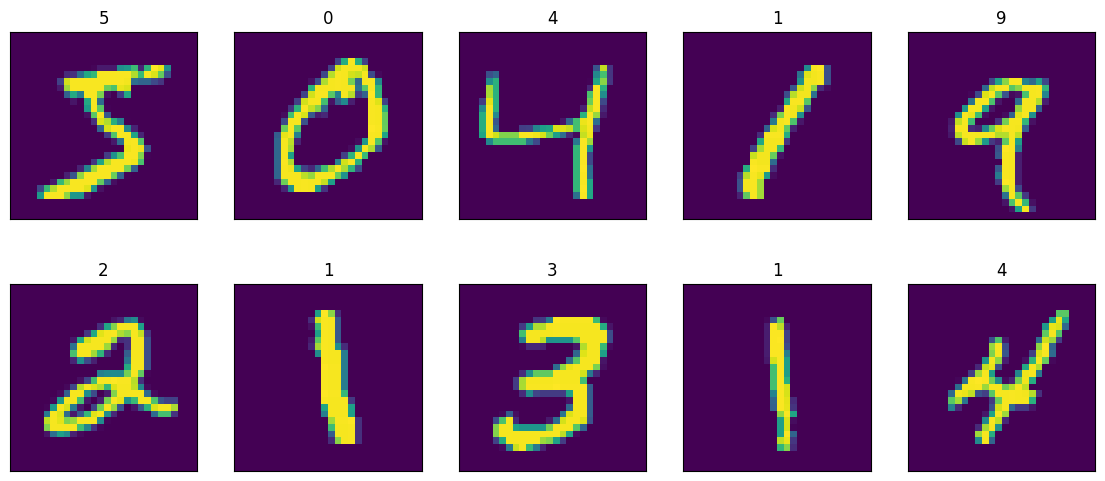

In [2]:
import matplotlib.pyplot as plt
plt.figure(figsize=(14,6))
for i in range(10):
    plt.subplot(2, 5, i+1)
    plt.imshow(train_mnist_ds.data[i].squeeze())
    plt.xticks([])
    plt.yticks([])
    plt.title('%d' % train_mnist_ds.targets[i])
plt.show()

The `test_mnist_ds.targets` and `train_mnist_ds.targets` values are currently integers (0 to 9).  The output from our network is a vector where one value should be 1 and the others should be 0 (one-hot encoding), so we need to convert to that format.  (Note: there is a special loss function called *sparse categorical crossentropy* that automatically converts for us. In `pytorch` the `CrossEntropyLoss` function provides that for us.  We'll use that later, but for now do this manually, just to keep things clear.)

In [3]:
y_train_target = torch.eye(10)[train_mnist_ds.targets]
y_test_target = torch.eye(10)[test_mnist_ds.targets]
print('original target:', train_mnist_ds.targets[0])
print('  vector target:', y_train_target[0])

original target: tensor(5)
  vector target: tensor([0., 0., 0., 0., 0., 1., 0., 0., 0., 0.])


Now we define the model using Keras https://keras.io/, which is meant for being able to quickly define all the different structures you might want to add to your network. We use `Sequential` to indicate that this is just a big feed-forward network, and we define each layer in turn.  `Linear` is a layer where all the components are connected to all of the previous layer's outputs.

In [4]:
import torch.nn as nn
 
def make_model(num_hidden = 32, num_out=10):
    m = nn.Sequential(
      nn.Flatten(),                       # input is a 28x28 image for MNIST
      nn.Linear(28*28, num_hidden, bias=True),    # 32 neurons in the middle "hidden" layer, have pytorch implement bias (default)
      nn.ReLU(),                          # Add nonlinearity
      nn.Linear(num_hidden, num_out, bias=True),       # 10 outputs (one for each category)
      nn.ReLU(),                          # Add nonlinearity
    )
    return m

We will also need to create dataloaders for training and testing the data. Before we move onto the crossentropy loss, we need to contruct a dataset and dataloader to use our one-hot encoding.

In [5]:
# Note we are applying the transform to the MNIST data here ourselves
train_ds = TensorDataset(transform(train_mnist_ds.data), y_train_target)
test_ds = TensorDataset(transform(test_mnist_ds.data), y_test_target)

train_loader = DataLoader(dataset=train_ds, batch_size=batch_size, shuffle=True)
test_loader = DataLoader(dataset=test_ds, batch_size=batch_size, shuffle=False)

Next, we setup the optimization step by specifying the optimizer and the loss function.

In [6]:
import torch.optim as optim

# define what we want to minimize (the thing that we take the derivative of to get the weight changes)
def criterion(y_true, y_predict):
    return torch.sum((y_true-y_predict)**2, dim=1)

model = make_model()
model = model.to(DEVICE)
optimizer = optim.SGD(model.parameters(), lr=0.1)

Before doing any training, let's see how well it performs.

In [7]:
losses = []
is_correct = []

model.eval() # <- Notice, we are switching the model into evaluation mode. No learning!
for images, labels in train_loader:
    images = images.to(DEVICE)
    labels = labels.to(DEVICE)
    outputs = model(images)
    loss = criterion(labels, outputs)
    losses.append(loss)
    is_correct.append(labels.argmax(dim=1) == outputs.argmax(dim=1))

losses = torch.cat(losses)
is_correct = torch.cat(is_correct)
print(f'MSE Loss: {torch.mean(losses).item():.2f}, Accuracy: {torch.mean(is_correct, dtype=torch.float32).item():.2f}')

MSE Loss: 0.96, Accuracy: 0.10


As expected, it's pretty bad, since we haven't done any training yet.  The accuracy is near 10%, which is what we would expect by chance.  But what actual numbers is it outputting?

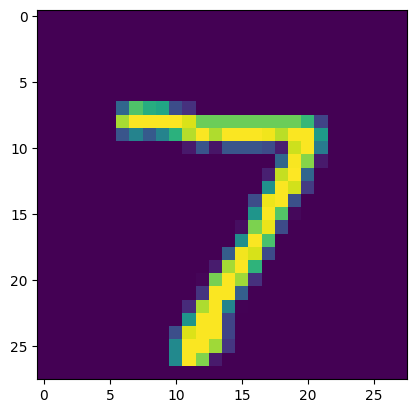

actual output from network: tensor([0.0763, 0.0000, 0.0713, 0.0515, 0.0000, 0.0826, 0.0919, 0.0000, 0.0000,
        0.0701], grad_fn=<SelectBackward0>)
category (the largest output): 6


In [8]:
output = model(test_loader.dataset.tensors[0].to(DEVICE))
category = output.argmax(dim=1)

plt.imshow(test_loader.dataset.tensors[0][0])
plt.show()
print('actual output from network:', output[0])
print('category (the largest output):', category[0].item())


So it currently thinks the first image in the test dataset is is a 7, when it should actually be a 1 (note: when you run this, you may get a different number, as each network starts out randomly different).  

Now let's try training the model.  We'll just do 5 epochs of training (5 times through all the training data).  While it is training, we also tell it to see how well the model is performing on the testing data (technically this is considered to be validation data, since we're looking at it while we are doing training.  Real testing data would only ever be used at the very end after all training has finished).

First we define a function to perform one epoch of training.

In [9]:
def train_one_epoch(model, criterion, accuracy_fn, optimizer, training_loader, epoch_index, batch_print=1000):
    model = model.to(DEVICE)
    running_loss = 0.
    last_loss = 0.

    # Here, we use enumerate(training_loader) instead of
    # iter(training_loader) so that we can track the batch
    # index and do some intra-epoch reporting
    
    correct = 0 # Count number of correct labels, assuming a classification task.
    for i, data in enumerate(training_loader):
        # Every data instance is an input + label pair
        inputs, labels = data
        inputs = inputs.to(DEVICE)
        labels = labels.to(DEVICE)

        # Zero your gradients for every batch!
        optimizer.zero_grad()

        # Make predictions for this batch
        outputs = model(inputs)

        # Compute the loss and its gradients
        loss = criterion(outputs, labels)
        loss.backward()

        # Adjust learning weights
        optimizer.step()
        
        correct += accuracy_fn(outputs, labels).item()

        # Gather data and report
        running_loss += loss.item()
        if i % batch_print == batch_print-1:
            last_loss = running_loss / 1000 # loss per batch
            print(f'  batch {i + 1} loss: {last_loss:.3e}')
            running_loss = 0.

    return last_loss, correct / len(training_loader.dataset)

Next we define the training loop

In [10]:
from datetime import datetime

def train_model(model, criterion, accuracy_fn, optimizer, training_loader, validation_loader=None, 
                num_epochs=5, batch_print=1000, eval_funcs=None, model_logging=False):
    timestamp = datetime.now().strftime('%Y%m%d_%H%M%S')
    best_vloss = 1_000_000.
    

    training_loss = []
    validation_loss = []
    
    training_accuracy = []
    validation_accuracy = []

    model = model.to(DEVICE)

    for epoch in range(num_epochs):
        print(f'EPOCH {epoch + 1}:')

        # Make sure gradient tracking is on, and do a pass over the data
        model.train(True) # <- Note, we are putting the model back in training mode.
        avg_loss, accuracy = train_one_epoch(model, criterion, accuracy_fn, optimizer, training_loader, epoch, batch_print=batch_print)


        training_loss.append(avg_loss)
        training_accuracy.append(accuracy)
        running_vloss = 0.0
        

        if validation_loader is None:
            # No validation data, skip evaluation
            continue
            
        # Set the model to evaluation mode, disabling dropout and using population
        # statistics for batch normalization.
        model.eval()
        
        # Disable gradient computation and reduce memory consumption.
        val_correct = 0
        with torch.no_grad():
            for i, vdata in enumerate(validation_loader):
                vinputs, vlabels = vdata
                vinputs = vinputs.to(DEVICE)
                vlabels = vlabels.to(DEVICE)
                voutputs = model(vinputs)
                vloss = criterion(voutputs, vlabels)
                running_vloss += vloss.item()

                val_correct += accuracy_fn(voutputs, vlabels).item()
                #(voutputs.argmax(dim=1)==vlabels.argmax(dim=1)).float().sum()

        avg_vloss = running_vloss / (i + 1)
        val_acc = val_correct / len(validation_loader.dataset)
        
        validation_loss.append(avg_vloss)
        validation_accuracy.append(val_acc)
        print(f'LOSS train {avg_loss:.3e} valid {avg_vloss:.3e}, train acc {accuracy:.2f}, val acc {val_acc:.2f}')

        # Track best performance, and save the model's state
        if model_logging and avg_vloss < best_vloss:
            best_vloss = avg_vloss
            model_path = 'model_{}_{}'.format(timestamp, epoch)
            torch.save(model.state_dict(), model_path)
        
    return {
        'loss':training_loss,
        'val_loss':validation_loss,
        'accuracy':training_accuracy,
        'val_accuracy':validation_accuracy,
           }


And, finally, we need to define a loss function in a way that is compatible with the Pytorch framework. This is something that will permit the automatic gradient to propagate back through the loss function.

In [11]:
class MeanSquareError(nn.Module):
    def __init__(self):
        super(MeanSquareError, self).__init__()
    def forward(self, y_true, y_pred):
        return torch.mean((y_true - y_pred)**2)
    
def one_hot_accuracy(y_pred, y_true):
    return (y_pred.argmax(dim=1) == y_true.argmax(dim=1)).float().sum()
    

**Note:** Below we have you recreate the model **and** the optimizer. If you model is not learning, make sure that the optimizer you are using is pointing at the parameters of the model you are trying to train. In other words, if you make a new model, you need to make a new optimizer too.

In [12]:
model = make_model()
model.train()

criterion = MeanSquareError() # Note, Pytorch provides nn.MSELoss(), but we want to see how to make our own loss.
optimizer = optim.SGD(model.parameters(), lr=0.1)
history = train_model(
    model, 
    criterion, 
    one_hot_accuracy, 
    optimizer, 
    train_loader, 
    test_loader, 
    num_epochs=5, 
    batch_print=100,
)

EPOCH 1:
  batch 100 loss: 7.786e-03
  batch 200 loss: 5.743e-03
  batch 300 loss: 4.704e-03
  batch 400 loss: 4.165e-03
  batch 500 loss: 3.741e-03
  batch 600 loss: 3.456e-03
  batch 700 loss: 3.424e-03
  batch 800 loss: 3.282e-03
  batch 900 loss: 3.085e-03
  batch 1000 loss: 3.055e-03
  batch 1100 loss: 3.003e-03
  batch 1200 loss: 2.930e-03
  batch 1300 loss: 2.846e-03
  batch 1400 loss: 2.778e-03
  batch 1500 loss: 2.971e-03
  batch 1600 loss: 2.939e-03
  batch 1700 loss: 2.810e-03
  batch 1800 loss: 2.830e-03
LOSS train 2.830e-03 valid 2.697e-02, train acc 0.78, val acc 0.83
EPOCH 2:
  batch 100 loss: 2.793e-03
  batch 200 loss: 2.670e-03
  batch 300 loss: 2.761e-03
  batch 400 loss: 2.660e-03
  batch 500 loss: 2.707e-03
  batch 600 loss: 2.657e-03
  batch 700 loss: 2.567e-03
  batch 800 loss: 2.653e-03
  batch 900 loss: 2.590e-03
  batch 1000 loss: 2.582e-03
  batch 1100 loss: 2.637e-03
  batch 1200 loss: 2.519e-03
  batch 1300 loss: 2.549e-03
  batch 1400 loss: 2.541e-03
  bat

We can plot the categorization accuracy over time and the error over time for both the training set and the test set.

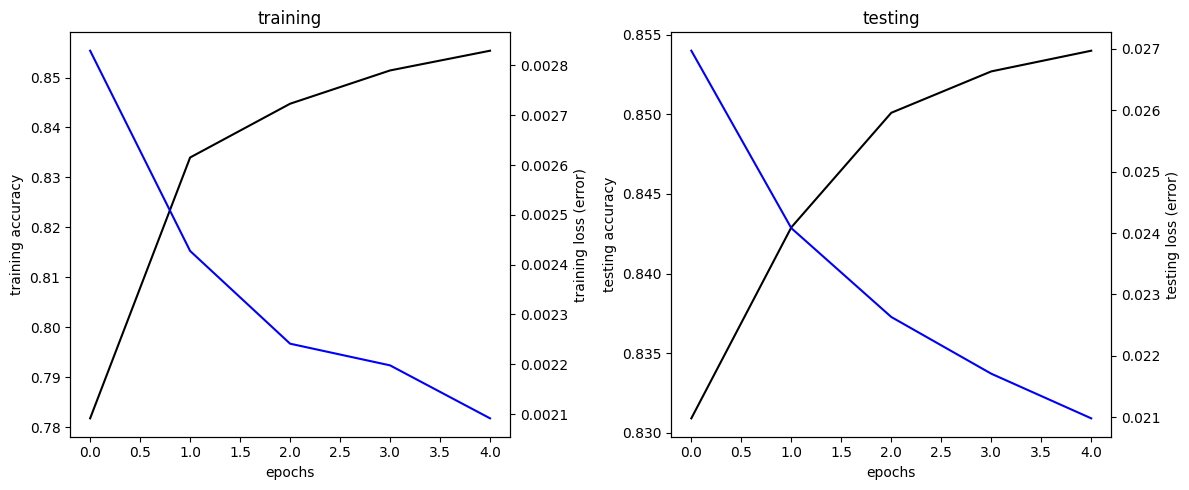

In [13]:
plt.figure(figsize=(12,5))
plt.subplot(1, 2, 1)
plt.plot(history['accuracy'], c='k')
plt.ylabel('training accuracy')
plt.xlabel('epochs')
plt.twinx()
plt.plot(history['loss'], c='b')
plt.ylabel('training loss (error)')
plt.title('training')

plt.subplot(1, 2, 2)
plt.plot(history['val_accuracy'], c='k')
plt.ylabel('testing accuracy')
plt.xlabel('epochs')
plt.twinx()
plt.plot(history['val_loss'], c='b')
plt.ylabel('testing loss (error)')
plt.title('testing')
plt.tight_layout()
plt.show()

Now let's see how well it performs on the test set.

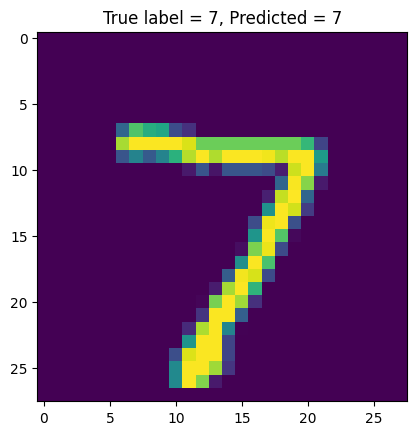

actual output from network: tensor([0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.9437, 0.0000,
        0.0000], grad_fn=<SelectBackward0>)
category (the largest output): tensor(7)


In [14]:
output = model(test_loader.dataset.tensors[0].to(DEVICE))
category = output.argmax(dim=1)

plt.imshow(test_loader.dataset.tensors[0][0])
plt.title(f'True label = {test_loader.dataset.tensors[1][0].argmax()}, Predicted = {category[0]}' )
plt.show()
print('actual output from network:', output[0])
print('category (the largest output):', category[0])

Well it learned the first item well, but it's only getting around 85% on the test set (which is also about what it's getting on the training set).  To get a better sense of what it's doing, let's generate the *confusion* matrix.  This indicates what category it puts things in, as compared to what category they should be in.

In [15]:
confusion=torch.zeros((10,10), dtype=int)
confusion=torch.index_put(confusion, (category, test_mnist_ds.targets), torch.LongTensor([1]), accumulate=True)
print(confusion)

tensor([[ 965,    0,    9,    5,    1,   13,    9,    3,   10,  341],
        [   0, 1120,    0,    0,    2,    2,    3,   10,    2,   16],
        [   2,    3,  957,   26,    4,    1,    2,   18,    3,    6],
        [   1,    2,    7,  932,    0,   26,    1,    4,   10,   36],
        [   1,    0,   14,    2,  956,    6,    9,    9,    7,  326],
        [   2,    1,    2,   11,    0,  802,    9,    2,   10,   17],
        [   7,    4,   10,    4,   10,   20,  921,    0,   13,    2],
        [   1,    2,   14,   10,    2,    5,    0,  979,   11,  219],
        [   1,    3,   19,   20,    7,   17,    4,    3,  908,   46],
        [   0,    0,    0,    0,    0,    0,    0,    0,    0,    0]])


The ideal confusion matrix will have ~1000 along the diagonal and 0 everywhere else.  According to this confusion matrix (yours will be different), 9's got mis-calssified as 4's a lot (and vice-versa).

**1. [1 mark]:** Run the MNIST model as defined here 10 times.  Note that you have to re-create the `model` each time: if you just run `train_model` over again, then it will just train the same model, continuing from where it left off.  Each of the 10 models should be trained for 5 epochs.  Make a single plot with training accuracy vs epoch for all 10 runs. Use the code to compute bootstrap confidence intervals from assignment 3. You should see that each time you train the model, it behaves differently.  Why does this happen? 


=== RUN 1/10 ===
  epoch 1: train acc = 0.8005
  epoch 2: train acc = 0.9079
  epoch 3: train acc = 0.9240
  epoch 4: train acc = 0.9331
  epoch 5: train acc = 0.9385

=== RUN 2/10 ===
  epoch 1: train acc = 0.7439
  epoch 2: train acc = 0.8098
  epoch 3: train acc = 0.8220
  epoch 4: train acc = 0.8299
  epoch 5: train acc = 0.8346

=== RUN 3/10 ===
  epoch 1: train acc = 0.8330
  epoch 2: train acc = 0.9139
  epoch 3: train acc = 0.9277
  epoch 4: train acc = 0.9366
  epoch 5: train acc = 0.9426

=== RUN 4/10 ===
  epoch 1: train acc = 0.6274
  epoch 2: train acc = 0.7199
  epoch 3: train acc = 0.7555
  epoch 4: train acc = 0.7615
  epoch 5: train acc = 0.7647

=== RUN 5/10 ===
  epoch 1: train acc = 0.7701
  epoch 2: train acc = 0.8276
  epoch 3: train acc = 0.8368
  epoch 4: train acc = 0.8432
  epoch 5: train acc = 0.8483

=== RUN 6/10 ===
  epoch 1: train acc = 0.8461
  epoch 2: train acc = 0.9101
  epoch 3: train acc = 0.9216
  epoch 4: train acc = 0.9302
  epoch 5: train acc =

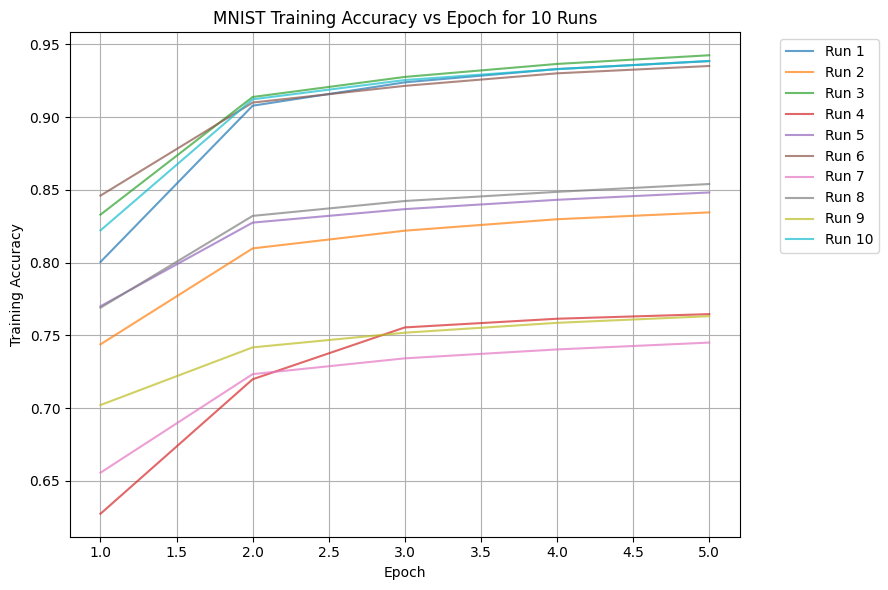

95% bootstrap CI for final-epoch training accuracy: [0.8084, 0.9023]


In [ ]:
import numpy as np

num_runs   = 10
num_epochs = 5

all_train_acc = np.zeros((num_runs, num_epochs))

def bootstrap_ci(values, num_bootstrap=2000, alpha=0.05):
    """Bootstrap CI for the mean of 'values'."""
    values = np.array(values)
    n = len(values)
    boot_means = []
    for _ in range(num_bootstrap):
        sample = np.random.choice(values, size=n, replace=True)
        boot_means.append(sample.mean())
    lower = np.percentile(boot_means, 100 * (alpha / 2))
    upper = np.percentile(boot_means, 100 * (1 - alpha / 2))
    return lower, upper

for run in range(num_runs):
    print(f"\n=== RUN {run+1}/{num_runs} ===")

    # Re-create model and optimizer each time
    model = make_model().to(DEVICE)
    criterion = MeanSquareError()
    optimizer = optim.SGD(model.parameters(), lr=0.1)

    for epoch in range(num_epochs):
        model.train()
        correct = 0
        total   = 0

        for xb, yb in train_loader:   # yb is one-hot
            xb, yb = xb.to(DEVICE), yb.to(DEVICE)

            optimizer.zero_grad()
            outputs = model(xb)
            loss = criterion(outputs, yb)
            loss.backward()
            optimizer.step()

            preds = outputs.argmax(dim=1)
            labels = yb.argmax(dim=1)
            correct += (preds == labels).sum().item()
            total   += labels.size(0)

        epoch_acc = correct / total
        all_train_acc[run, epoch] = epoch_acc
        print(f"  epoch {epoch+1}: train acc = {epoch_acc:.4f}")

epochs = np.arange(1, num_epochs + 1)

# plot
plt.figure(figsize=(9, 6))
for run in range(num_runs):
    plt.plot(epochs, all_train_acc[run, :], alpha=0.7, label=f"Run {run+1}")

plt.xlabel("Epoch")
plt.ylabel("Training Accuracy")
plt.title("MNIST Training Accuracy vs Epoch for 10 Runs")
plt.grid(True)
plt.legend(bbox_to_anchor=(1.05, 1), loc='upper left')  # legend moved outside
plt.tight_layout()
plt.show()

# bootstrap CI on final-epoch training accuracy
final_train_acc = all_train_acc[:, -1]
ci_low, ci_high = bootstrap_ci(final_train_acc)
print(
    f"95% bootstrap CI for final-epoch training accuracy: "
    f"[{ci_low:.4f}, {ci_high:.4f}]"
)

Each time the MNIST model is trained, it behaves differently because several sources of randomness influence the learning process. First, the neural network's weights are randomly initialized at the start of every run, and different initializations place the model at different locations in the loss landscape. Some initializations start closer to a good solution and learn faster, while others begin in poorer regions and converge much slower. Second, stochastic gradient descent introduces randomness through mini-batch sampling ad the irder in which the training is presented, which causes the optimization path to differ across runs. If training on a GPU, additional nondetereminstic oeprations can amplify these differences. Together, these factors cause each model run to follow a slightly different learning trajectory, resulting in the variation seen in the accuracy curves across the 10 runs.

**2. [1 mark]:** Do the same thing as question 1, but train for 20 epochs.  Plot the training error vs epochs, with confidence intervals, for 10 different runs on one plot.  On a separate plot show the testing error vs epochs for the 10 different runs.  How does the testing error compare to the training error?  Do the models all eventually learn to solve the problem well?  What happens to them?


=== RUN 1/10 ===
  epoch 1: train=0.6039, test=0.6537
  epoch 2: train=0.6856, test=0.7469
  epoch 3: train=0.7484, test=0.7578
  epoch 4: train=0.7547, test=0.7617
  epoch 5: train=0.7583, test=0.7640
  epoch 6: train=0.7625, test=0.7615
  epoch 7: train=0.7637, test=0.7649
  epoch 8: train=0.7672, test=0.7676
  epoch 9: train=0.7685, test=0.7681
  epoch 10: train=0.7702, test=0.7714
  epoch 11: train=0.7716, test=0.7716
  epoch 12: train=0.7730, test=0.7734
  epoch 13: train=0.7743, test=0.7728
  epoch 14: train=0.7754, test=0.7744
  epoch 15: train=0.7762, test=0.7743
  epoch 16: train=0.7766, test=0.7752
  epoch 17: train=0.7772, test=0.7766
  epoch 18: train=0.7784, test=0.7740
  epoch 19: train=0.7789, test=0.7753
  epoch 20: train=0.7794, test=0.7781

=== RUN 2/10 ===
  epoch 1: train=0.8302, test=0.9067
  epoch 2: train=0.9072, test=0.9174
  epoch 3: train=0.9211, test=0.9306
  epoch 4: train=0.9305, test=0.9364
  epoch 5: train=0.9372, test=0.9433
  epoch 6: train=0.9419, tes

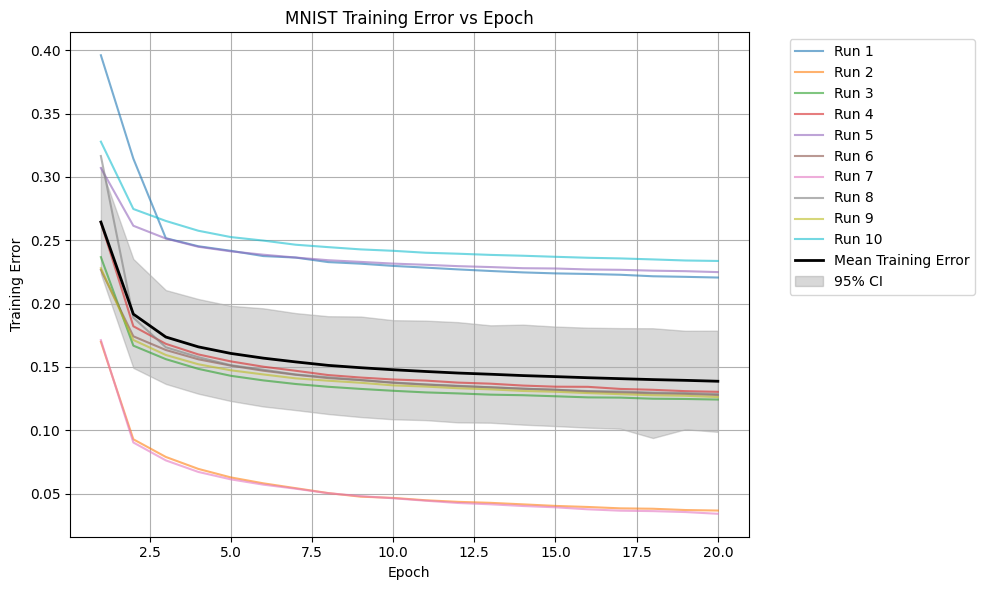

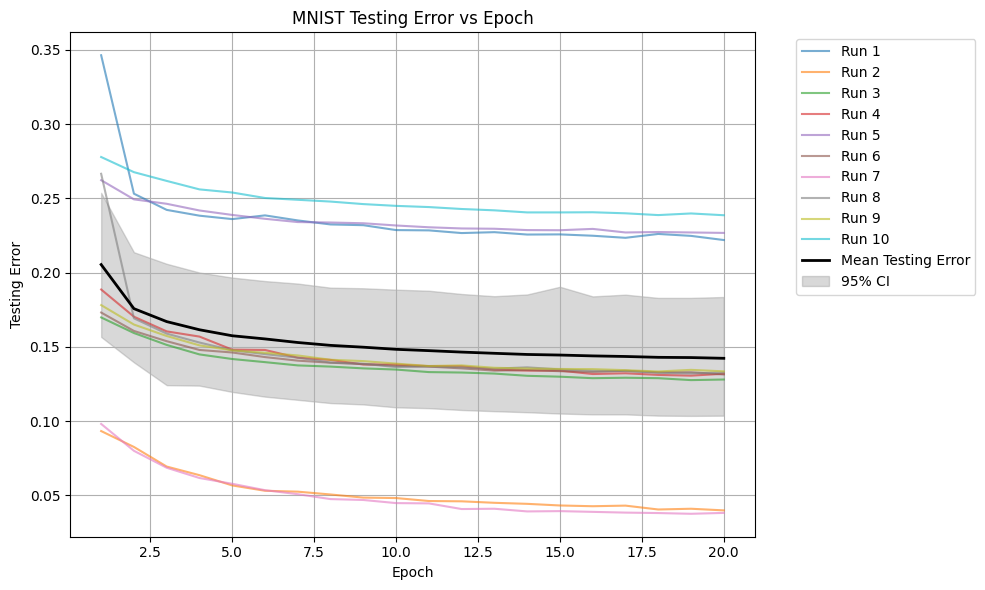

In [21]:
num_runs   = 10
num_epochs = 20

all_train_acc = np.zeros((num_runs, num_epochs))
all_test_acc  = np.zeros((num_runs, num_epochs))

def bootstrap_ci(values, num_bootstrap=2000, alpha=0.05):
    """Bootstrap CI for the mean of 'values'."""
    values = np.array(values)
    n = len(values)
    boot_means = []
    for _ in range(num_bootstrap):
        sample = np.random.choice(values, size=n, replace=True)
        boot_means.append(sample.mean())
    lower = np.percentile(boot_means, 100 * (alpha / 2))
    upper = np.percentile(boot_means, 100 * (1 - alpha / 2))
    return lower, upper

for run in range(num_runs):
    print(f"\n=== RUN {run+1}/{num_runs} ===")

    model = make_model().to(DEVICE)
    criterion = MeanSquareError()
    optimizer = optim.SGD(model.parameters(), lr=0.1)

    for epoch in range(num_epochs):
        # Training
        model.train()
        correct_train = 0
        total_train   = 0

        for xb, yb in train_loader:
            xb, yb = xb.to(DEVICE), yb.to(DEVICE)

            optimizer.zero_grad()
            outputs = model(xb)
            loss = criterion(outputs, yb)
            loss.backward()
            optimizer.step()

            preds  = outputs.argmax(dim=1)
            labels = yb.argmax(dim=1)
            correct_train += (preds == labels).sum().item()
            total_train   += labels.size(0)

        train_acc = correct_train / total_train
        all_train_acc[run, epoch] = train_acc

        # Testing
        model.eval()
        correct_test = 0
        total_test   = 0
        with torch.no_grad():
            for xb, yb in test_loader:
                xb, yb = xb.to(DEVICE), yb.to(DEVICE)
                outputs = model(xb)
                preds   = outputs.argmax(dim=1)
                labels  = yb.argmax(dim=1)
                correct_test += (preds == labels).sum().item()
                total_test   += labels.size(0)

        test_acc = correct_test / total_test
        all_test_acc[run, epoch] = test_acc

        print(f"  epoch {epoch+1}: train={train_acc:.4f}, test={test_acc:.4f}")

# Convert accuracy to error
train_err = 1.0 - all_train_acc
test_err  = 1.0 - all_test_acc

epochs = np.arange(1, num_epochs + 1)

# Training plot
plt.figure(figsize=(10, 6))

# Plot each run with labels
for run in range(num_runs):
    plt.plot(epochs, train_err[run, :], alpha=0.6, label=f"Run {run+1}")

# Compute CI for mean curve
mean_train_err = train_err.mean(axis=0)
ci_low_train   = np.zeros(num_epochs)
ci_high_train  = np.zeros(num_epochs)
for e in range(num_epochs):
    ci_low_train[e], ci_high_train[e] = bootstrap_ci(train_err[:, e])

# Plot mean + CI
plt.plot(epochs, mean_train_err, color="black", linewidth=2, label="Mean Training Error")
plt.fill_between(epochs, ci_low_train, ci_high_train, color="gray", alpha=0.3,
                 label="95% CI")

plt.xlabel("Epoch")
plt.ylabel("Training Error")
plt.title("MNIST Training Error vs Epoch")
plt.grid(True)
plt.legend(bbox_to_anchor=(1.05, 1), loc='upper left')
plt.tight_layout()
plt.show()

# Testing plot
plt.figure(figsize=(10, 6))

for run in range(num_runs):
    plt.plot(epochs, test_err[run, :], alpha=0.6, label=f"Run {run+1}")

# CI for test
mean_test_err = test_err.mean(axis=0)
ci_low_test   = np.zeros(num_epochs)
ci_high_test  = np.zeros(num_epochs)
for e in range(num_epochs):
    ci_low_test[e], ci_high_test[e] = bootstrap_ci(test_err[:, e])

plt.plot(epochs, mean_test_err, color="black", linewidth=2, label="Mean Testing Error")
plt.fill_between(epochs, ci_low_test, ci_high_test, color="gray", alpha=0.3,
                 label="95% CI")

plt.xlabel("Epoch")
plt.ylabel("Testing Error")
plt.title("MNIST Testing Error vs Epoch")
plt.grid(True)
plt.legend(bbox_to_anchor=(1.05, 1), loc='upper left')
plt.tight_layout()
plt.show()

Over 20 epochs, the training error for all ten runs decreases steadily, and every model eventually reaches a low training erro, showing that all networks are capable of fitting the MNIST training set well. Althought there is some variation between runs early in training due to different random initializations, these differences shrink over time, and the curves begin to converge as all the models continue to learn. The mean training error decreases smoothly, and the bootstrap confidence interval narrows, indicating reduced variability across runs as training progresses.
The testing error shows a similar patter but remains consistently higher than the training error across all peochs. This gap between training and testing error reflects the fact that the model fits the training data more closely than the unseen test data, demonstrating mild overfitting as training continoues. However, all ten runs still achieve relatively low test error by the end of training, meaning that every model ultimately learns to solve the MNIST classification tasks reasonably well. After roguhly the first few epochs, the testing error decreases more slowly and eventually plateaus, showing that additional training provides diminishing improvements in generalization. 

**3. [1 mark]:** Repeat question 2 (generating the same 2 plots), but with a learning rate of 0.01.  How does this affect the learning performance?


=== RUN 1/10 ===
  epoch 1: train=0.4668, test=0.6213
  epoch 2: train=0.6668, test=0.7526
  epoch 3: train=0.7637, test=0.7840
  epoch 4: train=0.7868, test=0.8054
  epoch 5: train=0.8034, test=0.8198
  epoch 6: train=0.8178, test=0.8294
  epoch 7: train=0.8287, test=0.8405
  epoch 8: train=0.8377, test=0.8480
  epoch 9: train=0.8445, test=0.8534
  epoch 10: train=0.8509, test=0.8583
  epoch 11: train=0.8553, test=0.8622
  epoch 12: train=0.8590, test=0.8678
  epoch 13: train=0.8633, test=0.8718
  epoch 14: train=0.8666, test=0.8734
  epoch 15: train=0.8700, test=0.8754
  epoch 16: train=0.8735, test=0.8762
  epoch 17: train=0.8760, test=0.8793
  epoch 18: train=0.8789, test=0.8821
  epoch 19: train=0.8814, test=0.8847
  epoch 20: train=0.8829, test=0.8864

=== RUN 2/10 ===
  epoch 1: train=0.4991, test=0.6623
  epoch 2: train=0.6816, test=0.7017
  epoch 3: train=0.7109, test=0.7203
  epoch 4: train=0.7224, test=0.7267
  epoch 5: train=0.7288, test=0.7319
  epoch 6: train=0.7334, tes

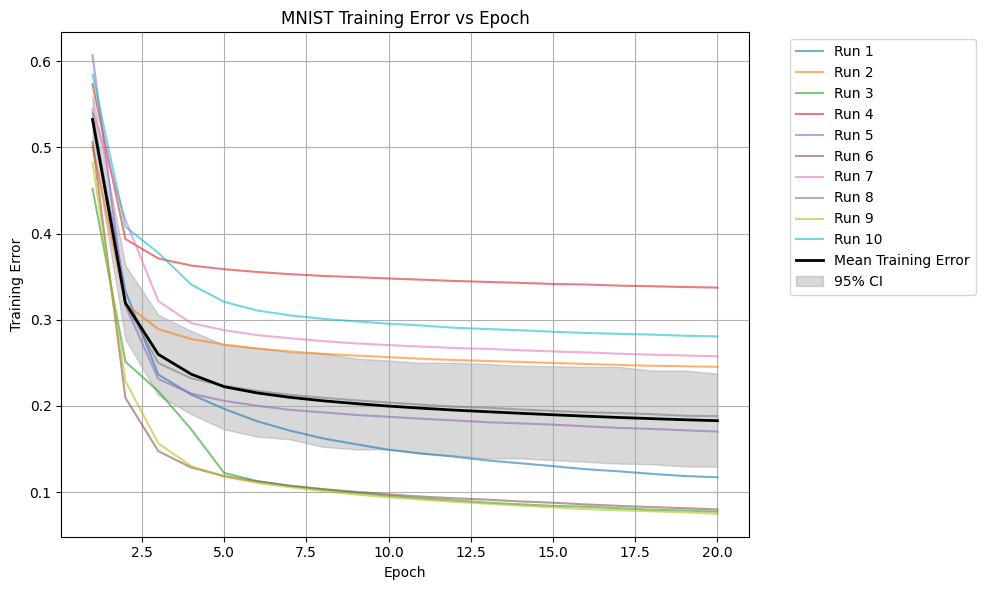

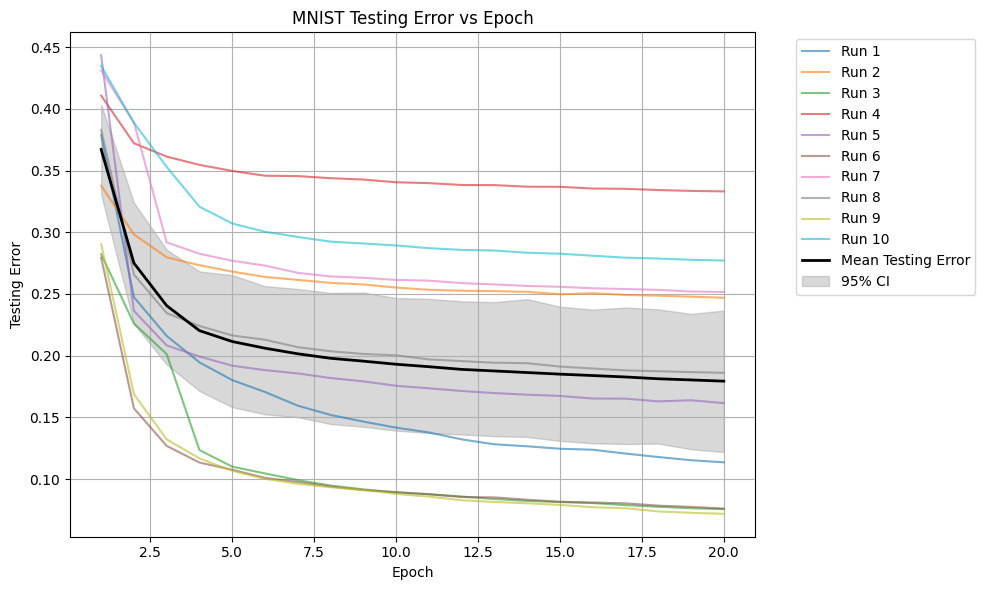

In [22]:
num_runs   = 10
num_epochs = 20

all_train_acc = np.zeros((num_runs, num_epochs))
all_test_acc  = np.zeros((num_runs, num_epochs))

def bootstrap_ci(values, num_bootstrap=2000, alpha=0.05):
    """Bootstrap CI for the mean of 'values'."""
    values = np.array(values)
    n = len(values)
    boot_means = []
    for _ in range(num_bootstrap):
        sample = np.random.choice(values, size=n, replace=True)
        boot_means.append(sample.mean())
    lower = np.percentile(boot_means, 100 * (alpha / 2))
    upper = np.percentile(boot_means, 100 * (1 - alpha / 2))
    return lower, upper

for run in range(num_runs):
    print(f"\n=== RUN {run+1}/{num_runs} ===")

    model = make_model().to(DEVICE)
    criterion = MeanSquareError()
    optimizer = optim.SGD(model.parameters(), lr=0.01)

    for epoch in range(num_epochs):
        # Training
        model.train()
        correct_train = 0
        total_train   = 0

        for xb, yb in train_loader:
            xb, yb = xb.to(DEVICE), yb.to(DEVICE)

            optimizer.zero_grad()
            outputs = model(xb)
            loss = criterion(outputs, yb)
            loss.backward()
            optimizer.step()

            preds  = outputs.argmax(dim=1)
            labels = yb.argmax(dim=1)
            correct_train += (preds == labels).sum().item()
            total_train   += labels.size(0)

        train_acc = correct_train / total_train
        all_train_acc[run, epoch] = train_acc

        # Testing
        model.eval()
        correct_test = 0
        total_test   = 0
        with torch.no_grad():
            for xb, yb in test_loader:
                xb, yb = xb.to(DEVICE), yb.to(DEVICE)
                outputs = model(xb)
                preds   = outputs.argmax(dim=1)
                labels  = yb.argmax(dim=1)
                correct_test += (preds == labels).sum().item()
                total_test   += labels.size(0)

        test_acc = correct_test / total_test
        all_test_acc[run, epoch] = test_acc

        print(f"  epoch {epoch+1}: train={train_acc:.4f}, test={test_acc:.4f}")

# Convert accuracy to error
train_err = 1.0 - all_train_acc
test_err  = 1.0 - all_test_acc

epochs = np.arange(1, num_epochs + 1)

# Training plot
plt.figure(figsize=(10, 6))

# Plot each run with labels
for run in range(num_runs):
    plt.plot(epochs, train_err[run, :], alpha=0.6, label=f"Run {run+1}")

# Compute CI for mean curve
mean_train_err = train_err.mean(axis=0)
ci_low_train   = np.zeros(num_epochs)
ci_high_train  = np.zeros(num_epochs)
for e in range(num_epochs):
    ci_low_train[e], ci_high_train[e] = bootstrap_ci(train_err[:, e])

# Plot mean + CI
plt.plot(epochs, mean_train_err, color="black", linewidth=2, label="Mean Training Error")
plt.fill_between(epochs, ci_low_train, ci_high_train, color="gray", alpha=0.3,
                 label="95% CI")

plt.xlabel("Epoch")
plt.ylabel("Training Error")
plt.title("MNIST Training Error vs Epoch")
plt.grid(True)
plt.legend(bbox_to_anchor=(1.05, 1), loc='upper left')
plt.tight_layout()
plt.show()

# Testing plot
plt.figure(figsize=(10, 6))

for run in range(num_runs):
    plt.plot(epochs, test_err[run, :], alpha=0.6, label=f"Run {run+1}")

# CI for test
mean_test_err = test_err.mean(axis=0)
ci_low_test   = np.zeros(num_epochs)
ci_high_test  = np.zeros(num_epochs)
for e in range(num_epochs):
    ci_low_test[e], ci_high_test[e] = bootstrap_ci(test_err[:, e])

plt.plot(epochs, mean_test_err, color="black", linewidth=2, label="Mean Testing Error")
plt.fill_between(epochs, ci_low_test, ci_high_test, color="gray", alpha=0.3,
                 label="95% CI")

plt.xlabel("Epoch")
plt.ylabel("Testing Error")
plt.title("MNIST Testing Error vs Epoch")
plt.grid(True)
plt.legend(bbox_to_anchor=(1.05, 1), loc='upper left')
plt.tight_layout()
plt.show()

Using a smaller learning rate slows down the learning process for all ten runs when compared to the original learning rate. In the training error plot, the error decreases much more gradually, especially during the first several epochs, because the model takes smaller steps during gradient descent. As a result, the networks require more epochs to reach the same level of training error achieved previously with a larger learning rate. The testing error shows the same trend. Although it steadily decreases, it does so at a slower rate, and many runs plateau at noticeably high error values than in question 2. This indicates that the models learn more cautiously and do not reach as low a test error within the same 20 epoch window.
Overall, reducing the learning rates makes the optimization more stable but significantly reduces the speed of learning. The models still ventually learn the MNIST task, but they converge more slowly and fail to reach the same degree of performance within the allotted number of epochs. The increased smoothness of the curves and tighter confidence intervals also show that the smaller learning rate reduces run to tun variability, but at the cost of weaker overall performance.

**4. [1 mark]:** Instead of standard Stochastic Gradient Descent, most modern machine learning researchers use a variation of it called [Adam](https://docs.pytorch.org/docs/stable/generated/torch.optim.Adam.html) that automatically adjusts the learning rate and does a better local estimate of the gradient.  We can switch to this by changing `optimizer=optim.SGD(model.parameters(), lr=0.1)` to `optimizer=optim.Adam(model.parameters())`.  Repeat question 2 (generating the same 2 plots) using the Adam optimizer.  How does this affect the learning performance?


=== RUN 1/10 (Adam) ===

=== RUN 2/10 (Adam) ===

=== RUN 3/10 (Adam) ===

=== RUN 4/10 (Adam) ===

=== RUN 5/10 (Adam) ===

=== RUN 6/10 (Adam) ===

=== RUN 7/10 (Adam) ===

=== RUN 8/10 (Adam) ===

=== RUN 9/10 (Adam) ===

=== RUN 10/10 (Adam) ===


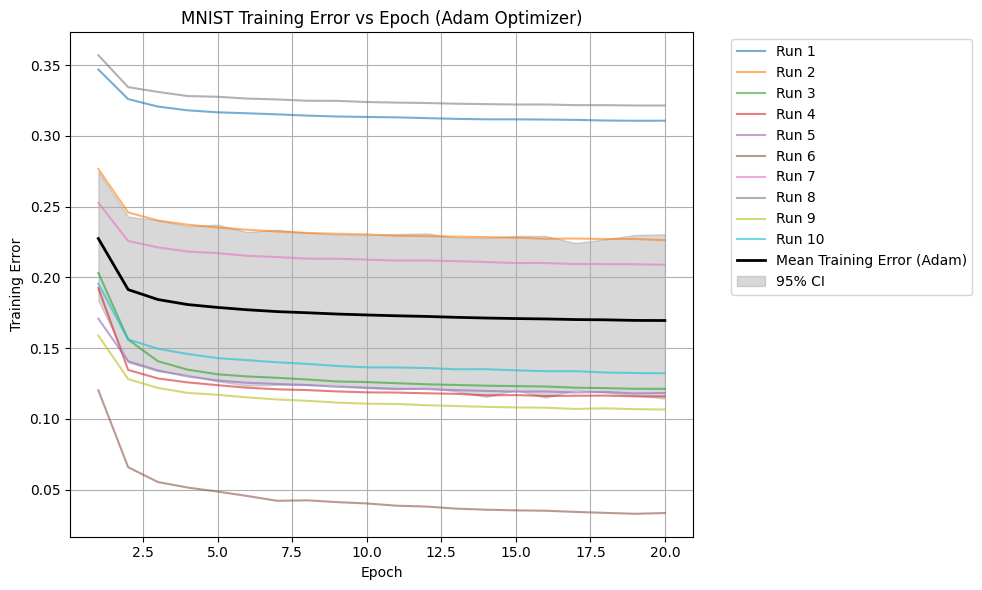

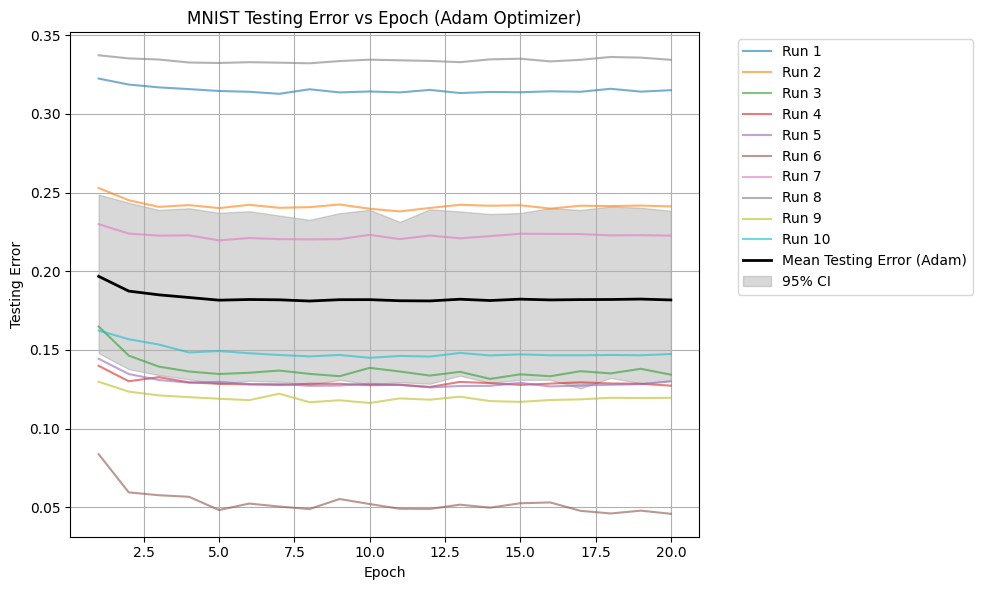

In [26]:
num_runs   = 10
num_epochs = 20

all_train_acc = np.zeros((num_runs, num_epochs))
all_test_acc  = np.zeros((num_runs, num_epochs))

def bootstrap_ci(values, num_bootstrap=2000, alpha=0.05):
    values = np.array(values)
    n = len(values)
    boot_means = []
    for _ in range(num_bootstrap):
        sample = np.random.choice(values, size=n, replace=True)
        boot_means.append(sample.mean())
    lower = np.percentile(boot_means, 100 * (alpha / 2))
    upper = np.percentile(boot_means, 100 * (1 - alpha / 2))
    return lower, upper

for run in range(num_runs):
    print(f"\n=== RUN {run+1}/{num_runs} (Adam) ===")

    model = make_model().to(DEVICE)
    criterion = MeanSquareError()

    # Adam Optimizer
    optimizer = optim.Adam(model.parameters())  

    for epoch in range(num_epochs):
        # Training
        model.train()
        correct_train = 0
        total_train   = 0

        for xb, yb in train_loader:
            xb, yb = xb.to(DEVICE), yb.to(DEVICE)

            optimizer.zero_grad()
            outputs = model(xb)
            loss = criterion(outputs, yb)
            loss.backward()
            optimizer.step()

            preds  = outputs.argmax(dim=1)
            labels = yb.argmax(dim=1)
            correct_train += (preds == labels).sum().item()
            total_train   += labels.size(0)

        all_train_acc[run, epoch] = correct_train / total_train

        # Testing
        model.eval()
        correct_test = 0
        total_test   = 0
        with torch.no_grad():
            for xb, yb in test_loader:
                xb, yb = xb.to(DEVICE), yb.to(DEVICE)
                outputs = model(xb)
                preds   = outputs.argmax(dim=1)
                labels  = yb.argmax(dim=1)
                correct_test += (preds == labels).sum().item()
                total_test   += labels.size(0)

        all_test_acc[run, epoch] = correct_test / total_test

# Convert to error
train_err = 1 - all_train_acc
test_err  = 1 - all_test_acc
epochs = np.arange(1, num_epochs + 1)

# Training error plot
plt.figure(figsize=(10, 6))
for run in range(num_runs):
    plt.plot(epochs, train_err[run], alpha=0.6, label=f"Run {run+1}")

mean_train_err = train_err.mean(axis=0)
ci_low_train, ci_high_train = [], []
for e in range(num_epochs):
    lo, hi = bootstrap_ci(train_err[:, e])
    ci_low_train.append(lo)
    ci_high_train.append(hi)

plt.plot(epochs, mean_train_err, color="black", linewidth=2, label="Mean Training Error (Adam)")
plt.fill_between(epochs, ci_low_train, ci_high_train, color="gray", alpha=0.3, label="95% CI")

plt.xlabel("Epoch")
plt.ylabel("Training Error")
plt.title("MNIST Training Error vs Epoch (Adam Optimizer)")
plt.legend(bbox_to_anchor=(1.05, 1), loc='upper left')
plt.grid(True)
plt.tight_layout()
plt.show()

# Testing error plot
plt.figure(figsize=(10, 6))
for run in range(num_runs):
    plt.plot(epochs, test_err[run], alpha=0.6, label=f"Run {run+1}")

mean_test_err = test_err.mean(axis=0)
ci_low_test, ci_high_test = [], []
for e in range(num_epochs):
    lo, hi = bootstrap_ci(test_err[:, e])
    ci_low_test.append(lo)
    ci_high_test.append(hi)

plt.plot(epochs, mean_test_err, color="black", linewidth=2, label="Mean Testing Error (Adam)")
plt.fill_between(epochs, ci_low_test, ci_high_test, color="gray", alpha=0.3, label="95% CI")

plt.xlabel("Epoch")
plt.ylabel("Testing Error")
plt.title("MNIST Testing Error vs Epoch (Adam Optimizer)")
plt.legend(bbox_to_anchor=(1.05, 1), loc='upper left')
plt.grid(True)
plt.tight_layout()
plt.show()

Using the Adam optimizer noticeably changes the learning behaviour compared to standard SGD with a fixed learning rate. In the training error plot, several runs converge faster and reach lower error earlier in training, showing that Adam's adaptive learning rates helps the model make more effective updates. However, unliked SGD, Adam also shows a wider spread of behaviours acrros runs. Some models learn very quickly and achieve extremely low training error, while others settle at significantly higher error values and do not improve as much. This increased variability is visible in the plots through the larger boostrap confidence interval.
The testing error shows the same pattern. A few runs achiever very low test error, indicating strong generalizaiton, but several other runs remain stuck at much higher error values even after 20 epochs. This suggests that while Adam can accelerate learning when the optimization trajectory is favourable, it can also get trapped in poorer solutions depending on the initial conditions. Overall, Adam improves the best case performance and speeds up early learning, but in the question 4 results it also introduces more run to run inconsistency compared to SGD leading to less stable generalization behaviour across the 10 repeated runs.

**5. [1 mark]**: To improve performance, we can also change the output layer of neurons to be a `softmax` layer.  This means that they will automatically be normalized with the softmax function (so the output of neuron $i$ will be ${e^{a_i} / \sum_j e^{a_j}}$).  This should push the output value closer to the sort of output we want (all zeros with a single 1).  Furthermore, instead of doing the error as $(t-y)^2$, we can instead choose an error function that is only concerned about categorization.  After all, the only thing we care about when categorizing is which of the outputs is largest, not whether they are exactly 0 or 1.  Conveniently, tensorflow (and many other deep learning libraries) also contains a version of this function that works directly on category labels, so we don't have to do the `y_train_target = torch.eye(10)[y_train]` trick in the code above.  The resulting network looks like this:

In [27]:
def make_softmax_model(num_hidden = 32, num_out=10):
    m = nn.Sequential(
      nn.Flatten(),                       # input is a 28x28 image for MNIST
      nn.Linear(28*28, num_hidden, bias=True),    # 32 neurons in the middle "hidden" layer, have pytorch implement bias (default)
      nn.ReLU(),                          # Add nonlinearity
      nn.Linear(num_hidden, num_out, bias=True),       # 10 outputs (one for each category)
      nn.Softmax(),                          # Add nonlinearity
    )
    return m


def cross_entropy_accuracy(y_pred, y_true):
    '''
    We need to change the accuracy function because the output is a vector encoding a distribution 
    over the categories, but the true label is just the class number.
    '''
    return (y_pred.argmax(dim=1) == y_true).float().sum()

In [28]:
softmax_model = make_softmax_model()

optimizer = optim.Adam(softmax_model.parameters()) # Note that you can set a learning rate for the Adam optimizer.
criterion = nn.CrossEntropyLoss()

history = train_model(
    softmax_model, 
    criterion, 
    cross_entropy_accuracy, 
    optimizer, 
    train_mnist_loader, 
    test_mnist_loader, 
    num_epochs=20, 
    batch_print=100,
)

EPOCH 1:
  batch 100 loss: 2.063e-01


/Users/asoliman/Desktop/Nano 4a/SYDE 522/.venv/lib/python3.13/site-packages/torch/nn/modules/module.py:1775: UserWarning: Implicit dimension choice for softmax has been deprecated. Change the call to include dim=X as an argument.
  return self._call_impl(*args, **kwargs)


  batch 200 loss: 1.773e-01
  batch 300 loss: 1.707e-01
  batch 400 loss: 1.654e-01
  batch 500 loss: 1.607e-01
  batch 600 loss: 1.593e-01
  batch 700 loss: 1.584e-01
  batch 800 loss: 1.581e-01
  batch 900 loss: 1.575e-01
  batch 1000 loss: 1.576e-01
  batch 1100 loss: 1.577e-01
  batch 1200 loss: 1.566e-01
  batch 1300 loss: 1.569e-01
  batch 1400 loss: 1.564e-01
  batch 1500 loss: 1.559e-01
  batch 1600 loss: 1.564e-01
  batch 1700 loss: 1.557e-01
  batch 1800 loss: 1.553e-01
LOSS train 1.553e-01 valid 1.547e+00, train acc 0.87, val acc 0.92
EPOCH 2:
  batch 100 loss: 1.554e-01
  batch 200 loss: 1.551e-01
  batch 300 loss: 1.544e-01
  batch 400 loss: 1.550e-01
  batch 500 loss: 1.546e-01
  batch 600 loss: 1.543e-01
  batch 700 loss: 1.545e-01
  batch 800 loss: 1.549e-01
  batch 900 loss: 1.544e-01
  batch 1000 loss: 1.550e-01
  batch 1100 loss: 1.544e-01
  batch 1200 loss: 1.540e-01
  batch 1300 loss: 1.537e-01
  batch 1400 loss: 1.533e-01
  batch 1500 loss: 1.540e-01
  batch 1600 

Generate the same 2 plots as in question 2.  How do these changes affect the learning performance?


=== RUN 1/10 (softmax + CE) ===
  epoch 1: train=0.8711, test=0.9207
  epoch 2: train=0.9263, test=0.9356
  epoch 3: train=0.9374, test=0.9420
  epoch 4: train=0.9460, test=0.9471
  epoch 5: train=0.9524, test=0.9483
  epoch 6: train=0.9559, test=0.9505
  epoch 7: train=0.9591, test=0.9513
  epoch 8: train=0.9619, test=0.9560
  epoch 9: train=0.9655, test=0.9586
  epoch 10: train=0.9673, test=0.9592
  epoch 11: train=0.9689, test=0.9596
  epoch 12: train=0.9704, test=0.9593
  epoch 13: train=0.9713, test=0.9614
  epoch 14: train=0.9725, test=0.9621
  epoch 15: train=0.9739, test=0.9628
  epoch 16: train=0.9747, test=0.9610
  epoch 17: train=0.9757, test=0.9623
  epoch 18: train=0.9764, test=0.9633
  epoch 19: train=0.9770, test=0.9628
  epoch 20: train=0.9777, test=0.9643

=== RUN 2/10 (softmax + CE) ===
  epoch 1: train=0.8805, test=0.9266
  epoch 2: train=0.9283, test=0.9349
  epoch 3: train=0.9393, test=0.9406
  epoch 4: train=0.9458, test=0.9445
  epoch 5: train=0.9506, test=0.948

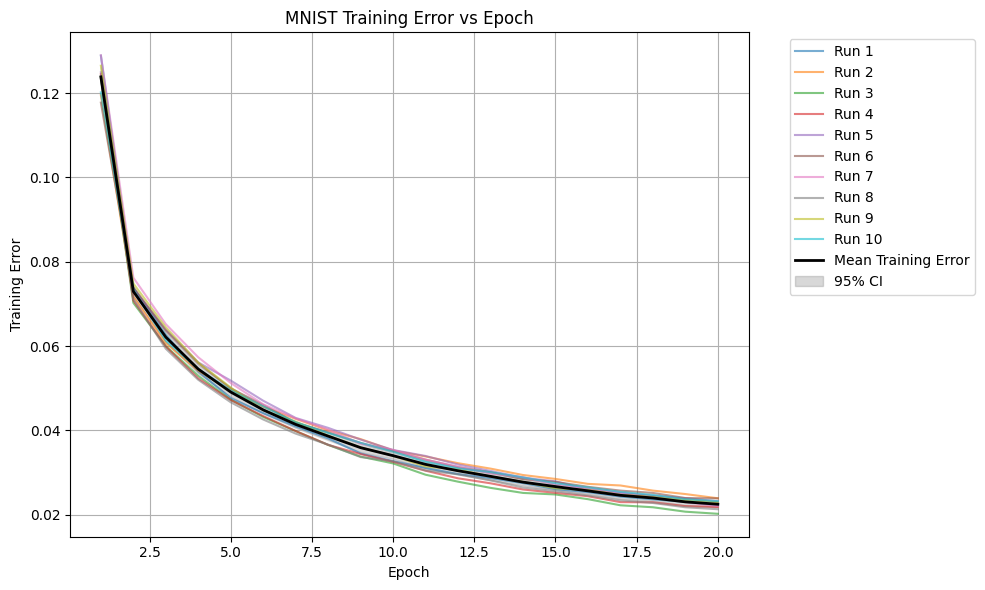

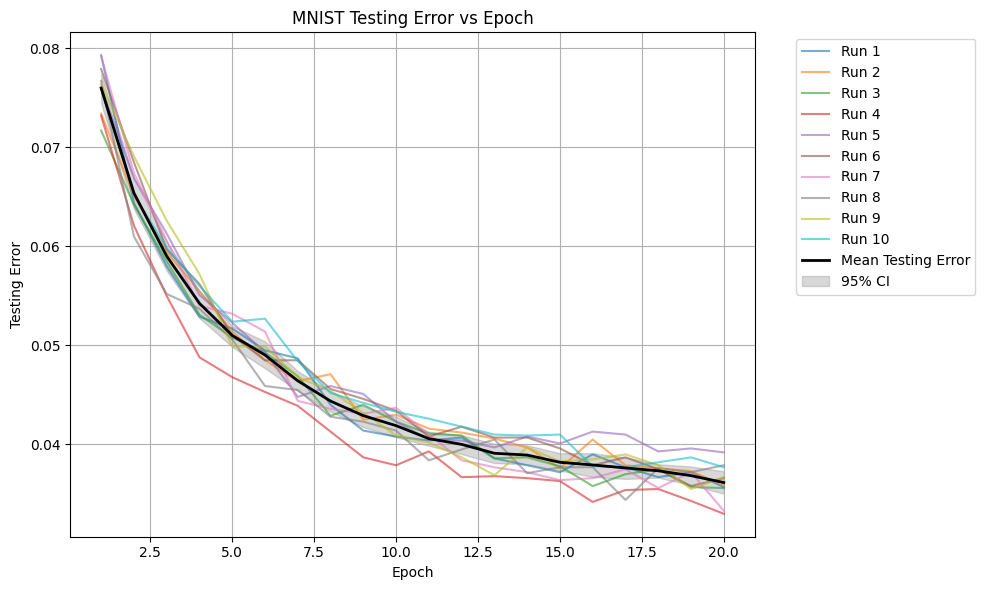

In [31]:
num_runs   = 10
num_epochs = 20

all_train_acc = np.zeros((num_runs, num_epochs))
all_test_acc  = np.zeros((num_runs, num_epochs))

def bootstrap_ci(values, num_bootstrap=2000, alpha=0.05):
    """Bootstrap CI for the mean of 'values'."""
    values = np.array(values)
    n = len(values)
    boot_means = []
    for _ in range(num_bootstrap):
        sample = np.random.choice(values, size=n, replace=True)
        boot_means.append(sample.mean())
    lower = np.percentile(boot_means, 100 * (alpha / 2))
    upper = np.percentile(boot_means, 100 * (1 - alpha / 2))
    return lower, upper


for run in range(num_runs):
    print(f"\n=== RUN {run+1}/{num_runs} (softmax + CE) ===")

    # Same model + optimizer + loss as in the instructor's cell
    model     = make_softmax_model().to(DEVICE)
    optimizer = optim.Adam(model.parameters())
    criterion = nn.CrossEntropyLoss()

    for epoch in range(num_epochs):
        # Training
        model.train()
        correct_train = 0
        total_train   = 0

        for xb, yb in train_mnist_loader:   
            xb, yb = xb.to(DEVICE), yb.to(DEVICE)

            optimizer.zero_grad()
            outputs = model(xb)             # softmax model
            loss    = criterion(outputs, yb)
            loss.backward()
            optimizer.step()

            preds = outputs.argmax(dim=1)
            correct_train += (preds == yb).sum().item()
            total_train   += yb.size(0)

        train_acc = correct_train / total_train
        all_train_acc[run, epoch] = train_acc

        # Testing
        model.eval()
        correct_test = 0
        total_test   = 0
        with torch.no_grad():
            for xb, yb in test_mnist_loader:
                xb, yb = xb.to(DEVICE), yb.to(DEVICE)
                outputs = model(xb)
                preds   = outputs.argmax(dim=1)
                correct_test += (preds == yb).sum().item()
                total_test   += yb.size(0)

        test_acc = correct_test / total_test
        all_test_acc[run, epoch] = test_acc

        print(f"  epoch {epoch+1}: train={train_acc:.4f}, test={test_acc:.4f}")


# convert accuracy to error 
train_err = 1.0 - all_train_acc
test_err  = 1.0 - all_test_acc
epochs    = np.arange(1, num_epochs + 1)

# Training error plot
plt.figure(figsize=(10, 6))
for run in range(num_runs):
    plt.plot(epochs, train_err[run], alpha=0.6, label=f"Run {run+1}")

mean_train_err = train_err.mean(axis=0)
ci_low_train, ci_high_train = [], []
for e in range(num_epochs):
    lo, hi = bootstrap_ci(train_err[:, e])
    ci_low_train.append(lo)
    ci_high_train.append(hi)

plt.plot(epochs, mean_train_err, color="black", linewidth=2,
         label="Mean Training Error")
plt.fill_between(epochs, ci_low_train, ci_high_train,
                 color="gray", alpha=0.3, label="95% CI")

plt.xlabel("Epoch")
plt.ylabel("Training Error")
plt.title("MNIST Training Error vs Epoch")
plt.legend(bbox_to_anchor=(1.05, 1), loc="upper left")
plt.grid(True)
plt.tight_layout()
plt.show()

# Testing error plot
plt.figure(figsize=(10, 6))
for run in range(num_runs):
    plt.plot(epochs, test_err[run], alpha=0.6, label=f"Run {run+1}")

mean_test_err = test_err.mean(axis=0)
ci_low_test, ci_high_test = [], []
for e in range(num_epochs):
    lo, hi = bootstrap_ci(test_err[:, e])
    ci_low_test.append(lo)
    ci_high_test.append(hi)

plt.plot(epochs, mean_test_err, color="black", linewidth=2,
         label="Mean Testing Error")
plt.fill_between(epochs, ci_low_test, ci_high_test,
                 color="gray", alpha=0.3, label="95% CI")

plt.xlabel("Epoch")
plt.ylabel("Testing Error")
plt.title("MNIST Testing Error vs Epoch")
plt.legend(bbox_to_anchor=(1.05, 1), loc="upper left")
plt.grid(True)
plt.tight_layout()
plt.show()

Switching to the softmax output layer with cross-entropy loss and the Adam optimizer leads to a clear improvement in learning performance compared to the earlier mdoels in question 2. In the training error plot, the error decreases rapidly and smoothly across all 10 runs, and the final training error is significantly lower than what was achieved with the previous network. The curves from different runs almost overlap, showing that this setup learns consistently regardless of intialization.
The testing error behaves similarly. It decreases steadily throughout training, reaching much lower error values than before. The testing curves remain tightly grouped, and the confidence interval is narrow, indicating that the model generalizes quite well across all runs. Compared to question 2, the combination of softmax + cross-entropy + Adam yields faster convergence, lower final errors, and greatly reduced variability between runs. Overall, these changes produce a more stable and more accurate model.

**6. [2 marks]:** Using the final version of the model (from question 5), explore the performance of the model as you change the number of neurons in the hidden layer.  Try 2, 4, 8, 16, 32, 64, 128, and 256.  For each value, train 10 models for 10 epochs each.  We do not need the testing accuracy over the epochs, so you can switch back to setting `num_epochs=10` rather than using the `for` loop.  Plot the average training accuracy (with confidence intervals) vs different numbers of neurons.  On a separate plot, plot the average testing accuracy (with confidence intervals) vs different numbers of neurons.  What trend do you observe?


=== Hidden units: 2 ===
  Run 1/10
EPOCH 1:
  batch 100 loss: 2.282e-01
  batch 200 loss: 2.235e-01
  batch 300 loss: 2.182e-01
  batch 400 loss: 2.156e-01
  batch 500 loss: 2.135e-01
  batch 600 loss: 2.115e-01
  batch 700 loss: 2.115e-01
  batch 800 loss: 2.106e-01
  batch 900 loss: 2.098e-01
  batch 1000 loss: 2.089e-01
  batch 1100 loss: 2.087e-01
  batch 1200 loss: 2.084e-01
  batch 1300 loss: 2.073e-01
  batch 1400 loss: 2.068e-01
  batch 1500 loss: 2.058e-01
  batch 1600 loss: 2.045e-01
  batch 1700 loss: 2.044e-01
  batch 1800 loss: 2.031e-01
LOSS train 2.031e-01 valid 2.023e+00, train acc 0.36, val acc 0.48
EPOCH 2:
  batch 100 loss: 2.020e-01
  batch 200 loss: 2.009e-01
  batch 300 loss: 2.011e-01
  batch 400 loss: 2.014e-01
  batch 500 loss: 1.999e-01
  batch 600 loss: 2.000e-01
  batch 700 loss: 1.997e-01
  batch 800 loss: 1.994e-01
  batch 900 loss: 1.979e-01
  batch 1000 loss: 1.979e-01
  batch 1100 loss: 1.969e-01
  batch 1200 loss: 1.972e-01
  batch 1300 loss: 1.968e-0

TypeError: LogScale.__init__() got an unexpected keyword argument 'basex'. Did you mean 'base'?

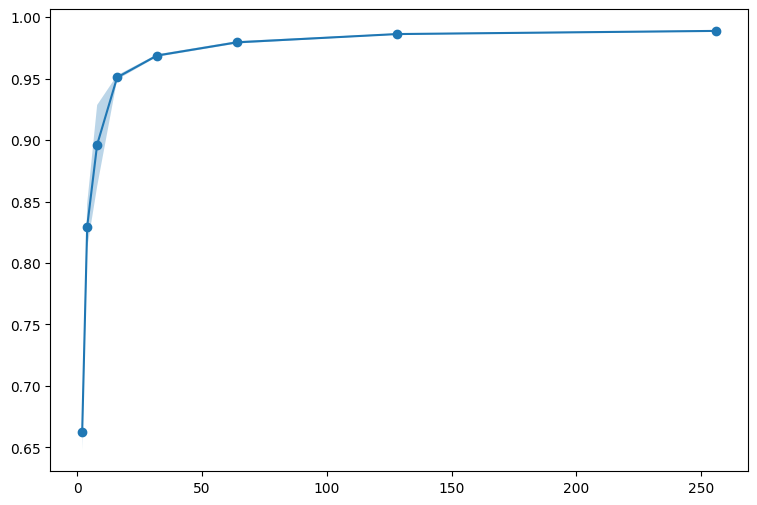

In [ ]:
hidden_sizes = [2, 4, 8, 16, 32, 64, 128, 256]
num_runs     = 10
num_epochs   = 10

train_acc = np.zeros((len(hidden_sizes), num_runs))
test_acc  = np.zeros((len(hidden_sizes), num_runs))

def bootstrap_ci(values, num_bootstrap=2000, alpha=0.05):
    """Bootstrap CI for the mean of 'values'."""
    values = np.array(values)
    n = len(values)
    boot_means = []
    for _ in range(num_bootstrap):
        sample = np.random.choice(values, size=n, replace=True)
        boot_means.append(sample.mean())
    lower = np.percentile(boot_means, 100 * (alpha / 2))
    upper = np.percentile(boot_means, 100 * (1 - alpha / 2))
    return lower, upper

def compute_accuracy(model, data_loader):
    """Compute average accuracy over a loader (train or test)."""
    model.eval()
    correct = 0
    total   = 0
    with torch.no_grad():
        for xb, yb in data_loader:
            xb, yb = xb.to(DEVICE), yb.to(DEVICE)
            outputs = model(xb)
            preds   = outputs.argmax(dim=1)
            correct += (preds == yb).sum().item()
            total   += yb.size(0)
    return correct / total

for i, h in enumerate(hidden_sizes):
    print(f"\n=== Hidden units: {h} ===")
    for run in range(num_runs):
        print(f"  Run {run+1}/{num_runs}")

        # Final model from Q5, but with variable hidden size
        model     = make_softmax_model(num_hidden=h).to(DEVICE)
        criterion = nn.CrossEntropyLoss()
        optimizer = optim.Adam(model.parameters())

        # Train for 10 epochs 
        history = train_model(
            model,
            criterion,
            cross_entropy_accuracy,
            optimizer,
            train_mnist_loader,
            test_mnist_loader,
            num_epochs=num_epochs,
            batch_print=100,
        )

        # Final train/test accuracy after 10 epochs
        train_acc[i, run] = compute_accuracy(model, train_mnist_loader)
        test_acc[i, run]  = compute_accuracy(model, test_mnist_loader)

# Training accuracy vs hidden size
mean_train = train_acc.mean(axis=1)
ci_low_train = []
ci_high_train = []
for i in range(len(hidden_sizes)):
    lo, hi = bootstrap_ci(train_acc[i, :])
    ci_low_train.append(lo)
    ci_high_train.append(hi)

x = np.array(hidden_sizes, dtype=float)

plt.figure(figsize=(9, 6))
plt.plot(x, mean_train, marker="o", label="Mean training accuracy")
plt.fill_between(x, ci_low_train, ci_high_train, alpha=0.3, label="95% CI")
plt.xscale("log", base=2)  # optional: log scale since sizes double
plt.xticks(hidden_sizes, hidden_sizes)
plt.xlabel("Number of hidden neurons")
plt.ylabel("Training accuracy")
plt.title("Training accuracy vs hidden layer size")
plt.grid(True)
plt.legend()
plt.tight_layout()
plt.show()

# Testing accuracy vs hidden size
mean_test = test_acc.mean(axis=1)
ci_low_test = []
ci_high_test = []
for i in range(len(hidden_sizes)):
    lo, hi = bootstrap_ci(test_acc[i, :])
    ci_low_test.append(lo)
    ci_high_test.append(hi)

plt.figure(figsize=(9, 6))
plt.plot(x, mean_test, marker="o", label="Mean testing accuracy")
plt.fill_between(x, ci_low_test, ci_high_test, alpha=0.3, label="95% CI")
plt.xscale("log", base=2)
plt.xticks(hidden_sizes, hidden_sizes)
plt.xlabel("Number of hidden neurons")
plt.ylabel("Testing accuracy")
plt.title("Testing accuracy vs hidden layer size")
plt.grid(True)
plt.legend()
plt.tight_layout()
plt.show()

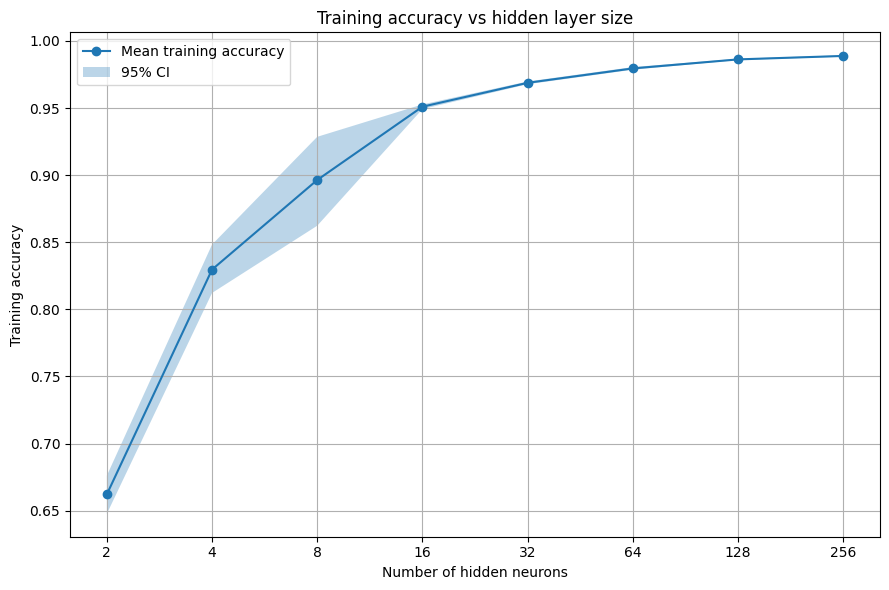

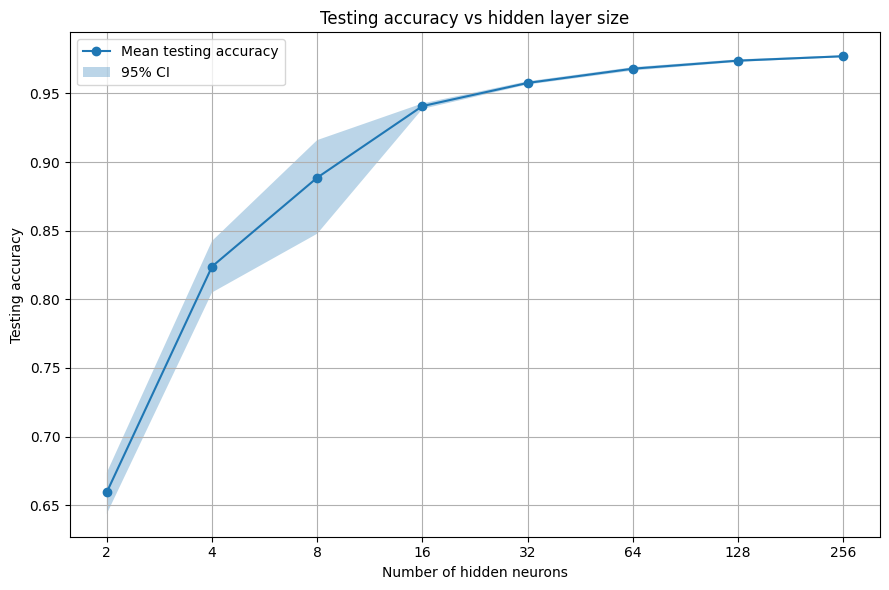

In [ ]:
plt.figure(figsize=(9, 6))
plt.plot(x, mean_train, marker="o", label="Mean training accuracy")
plt.fill_between(x, ci_low_train, ci_high_train, alpha=0.3, label="95% CI")
plt.xscale("log", base=2)  # log scale since sizes double
plt.xticks(hidden_sizes, hidden_sizes)
plt.xlabel("Number of hidden neurons")
plt.ylabel("Training accuracy")
plt.title("Training accuracy vs hidden layer size")
plt.grid(True)
plt.legend()
plt.tight_layout()
plt.show()

# Testing accuracy vs hidden size 
mean_test = test_acc.mean(axis=1)
ci_low_test = []
ci_high_test = []
for i in range(len(hidden_sizes)):
    lo, hi = bootstrap_ci(test_acc[i, :])
    ci_low_test.append(lo)
    ci_high_test.append(hi)

plt.figure(figsize=(9, 6))
plt.plot(x, mean_test, marker="o", label="Mean testing accuracy")
plt.fill_between(x, ci_low_test, ci_high_test, alpha=0.3, label="95% CI")
plt.xscale("log", base=2)
plt.xticks(hidden_sizes, hidden_sizes)
plt.xlabel("Number of hidden neurons")
plt.ylabel("Testing accuracy")
plt.title("Testing accuracy vs hidden layer size")
plt.grid(True)
plt.legend()
plt.tight_layout()
plt.show()

As the number of hidden neurons increases from 2 up to 256, both the average training accuracy and the average testing accuracy consistently improve. With a very small hidden layer, the model underfits the data and achieves relatively low accuracy. Increasing the hidden layer size improves the model's capacity, allowing it to learn more expressive decision boundaries, which results in rapid rise in accuracy between 2, 4, 8, and 16 neurons. Beyond 32 neurons, the gains in both training and testing accuracy begin to taper off. While accuracy continues to increase slightly up to 256 neaurons, the improvements become marginal, showing diminishing returns at larger model sizes. The confidence intervals also shrink as the number of neaurons increases, indicating more stable and consistent performance across the 10 runs. Overall, the trend shows that larger hiddens layers improve performance, bur after a certain point, adding more neaurons provides only small incremental benefits, suggesting that overly large hidden layers do not substantially improve generalization for this MNIST classification task.

**7. [2 marks]:** The overall goal is to make the network perform as well as possible on the testing data.  What would you do if your job was to make the best possible network for this task?  Try some things and report your results.  For example, try adding a second hidden layer to the model.  Try making it different sizes. What about having no hidden layer?  Or more than 2?  Report the results of your exploration.

In [ ]:
# helper: compute accuracy on a whole loader 
def compute_accuracy(model, data_loader):
    model.eval()
    correct = 0
    total   = 0
    with torch.no_grad():
        for xb, yb in data_loader:
            xb, yb = xb.to(DEVICE), yb.to(DEVICE)
            outputs = model(xb)
            preds   = outputs.argmax(dim=1)
            correct += (preds == yb).sum().item()
            total   += yb.size(0)
    return correct / total

# new model variants
def make_no_hidden_model(num_out=10):
    """Logistic regression: no hidden layer."""
    m = nn.Sequential(
        nn.Flatten(),
        nn.Linear(28 * 28, num_out, bias=True),
        nn.Softmax(dim=1),
    )
    return m

def make_two_hidden_model(h1=128, h2=64, num_out=10):
    """Two hidden layers with ReLU, softmax output."""
    m = nn.Sequential(
        nn.Flatten(),
        nn.Linear(28 * 28, h1, bias=True),
        nn.ReLU(),
        nn.Linear(h1, h2, bias=True),
        nn.ReLU(),
        nn.Linear(h2, num_out, bias=True),
        nn.Softmax(dim=1),
    )
    return m

# Architectures to try: (name, constructor_function)
architectures = [
    ("no_hidden",              lambda: make_no_hidden_model()),
    ("one_hidden_128",         lambda: make_softmax_model(num_hidden=128)),
    ("two_hidden_128_64",      lambda: make_two_hidden_model(128, 64)),
    ("two_hidden_256_128",     lambda: make_two_hidden_model(256, 128)),
]

num_epochs = 20  

results = []

for name, make_model_fn in architectures:
    print(f"\n=== Training architecture: {name} ===")
    model = make_model_fn().to(DEVICE)

    criterion = nn.CrossEntropyLoss()
    optimizer = optim.Adam(model.parameters())

    # use the provided training loop from the assignment
    _ = train_model(
        model,
        criterion,
        cross_entropy_accuracy,
        optimizer,
        train_mnist_loader,
        test_mnist_loader,
        num_epochs=num_epochs,
        batch_print=100,
    )

    # final accuracies after training
    train_acc = compute_accuracy(model, train_mnist_loader)
    test_acc  = compute_accuracy(model, test_mnist_loader)

    results.append((name, train_acc, test_acc))

# print a summary table of the exploration
print("\nSummary of architectures:")
for name, train_acc, test_acc in results:
    print(f"{name:20s}  train_acc = {train_acc:.4f},  test_acc = {test_acc:.4f}")


=== Training architecture: no_hidden ===
EPOCH 1:
  batch 100 loss: 2.070e-01
  batch 200 loss: 1.791e-01
  batch 300 loss: 1.711e-01
  batch 400 loss: 1.674e-01
  batch 500 loss: 1.656e-01
  batch 600 loss: 1.630e-01
  batch 700 loss: 1.639e-01
  batch 800 loss: 1.619e-01
  batch 900 loss: 1.612e-01
  batch 1000 loss: 1.606e-01
  batch 1100 loss: 1.604e-01
  batch 1200 loss: 1.603e-01
  batch 1300 loss: 1.595e-01
  batch 1400 loss: 1.591e-01
  batch 1500 loss: 1.591e-01
  batch 1600 loss: 1.586e-01
  batch 1700 loss: 1.587e-01
  batch 1800 loss: 1.582e-01
LOSS train 1.582e-01 valid 1.573e+00, train acc 0.87, val acc 0.91
EPOCH 2:
  batch 100 loss: 1.571e-01
  batch 200 loss: 1.579e-01
  batch 300 loss: 1.573e-01
  batch 400 loss: 1.571e-01
  batch 500 loss: 1.573e-01
  batch 600 loss: 1.574e-01
  batch 700 loss: 1.568e-01
  batch 800 loss: 1.561e-01
  batch 900 loss: 1.570e-01
  batch 1000 loss: 1.562e-01
  batch 1100 loss: 1.571e-01
  batch 1200 loss: 1.573e-01
  batch 1300 loss: 1.

/Users/asoliman/Desktop/Nano 4a/SYDE 522/.venv/lib/python3.13/site-packages/torch/nn/modules/module.py:1775: UserWarning: Implicit dimension choice for softmax has been deprecated. Change the call to include dim=X as an argument.
  return self._call_impl(*args, **kwargs)


  batch 200 loss: 1.703e-01
  batch 300 loss: 1.672e-01
  batch 400 loss: 1.662e-01
  batch 500 loss: 1.635e-01
  batch 600 loss: 1.582e-01
  batch 700 loss: 1.579e-01
  batch 800 loss: 1.559e-01
  batch 900 loss: 1.559e-01
  batch 1000 loss: 1.565e-01
  batch 1100 loss: 1.548e-01
  batch 1200 loss: 1.547e-01
  batch 1300 loss: 1.547e-01
  batch 1400 loss: 1.551e-01
  batch 1500 loss: 1.535e-01
  batch 1600 loss: 1.531e-01
  batch 1700 loss: 1.534e-01
  batch 1800 loss: 1.533e-01
LOSS train 1.533e-01 valid 1.532e+00, train acc 0.88, val acc 0.93
EPOCH 2:
  batch 100 loss: 1.538e-01
  batch 200 loss: 1.526e-01
  batch 300 loss: 1.529e-01
  batch 400 loss: 1.526e-01
  batch 500 loss: 1.520e-01
  batch 600 loss: 1.521e-01
  batch 700 loss: 1.523e-01
  batch 800 loss: 1.523e-01
  batch 900 loss: 1.524e-01
  batch 1000 loss: 1.522e-01
  batch 1100 loss: 1.514e-01
  batch 1200 loss: 1.520e-01
  batch 1300 loss: 1.513e-01
  batch 1400 loss: 1.518e-01
  batch 1500 loss: 1.518e-01
  batch 1600 

To improve the model's performance on the MNIST testing data, I experimented with several architectural variations, including removing the hidden layer entirely, increasing the size of the hidden layer, and adding a second hidden layer. The goal was to find the architecture that produced the lowest testing error. The baseline model with no hidden layer performed reasonably well, achieving a test accuracy of around 93%, but it was noticeably worse than models that included at least one hidden layer. Adding a single hidden layer with 128 neurons significantly improved performance, reaching a test accuracy of around 96%, which was the strongest result among all the models I tested. I then explored two-layer architectures of different sizes. A model with hidden layers of 128 to 64 neurons reached around 97% test accuracy, and a larger architecture with 256 to 128 neurons produced around 97% as well. Although both two hidden layer models performed well, neither outperformed the simpler one hidden layer model with 128 neurons. Overall, the results suggest that adding some hidden capacity improves performance, but increasing the depth or size beyond a certain point doesn't entirely mean better accuracy and may even slightly reduce generalization due to overfitting. The best performing architecture in this exploration was the one hidden layer with 128 neurons, which balanced representational capacity and generalizaiton most effectively. 

## Part 2: CIFAR-10

The CIFAR-10 dataset is a bit harder than the MNIST dataset.  Like MNIST, it consists of 10 categories of images, but now they are colour images and they are of different types of objects.

In [35]:
transform = v2.Compose([
    v2.ToImage(), # Note, this will put the colour channel in the right axis position.
    v2.ToDtype(torch.float32, scale=True),
])

train_cifar_ds = datasets.CIFAR10(root='data', train=True, download=True, transform=transform)
test_cifar_ds = datasets.CIFAR10(root='data', train=False, download=True, transform=transform)

train_cifar_loader = DataLoader(dataset=train_cifar_ds, batch_size=batch_size, shuffle=True)
test_cifar_loader = DataLoader(dataset=test_cifar_ds, batch_size=batch_size, shuffle=False)

names = ['airplane', 'automobile', 'bird', 'cat', 'deer', 'dog', 'frog', 'horse', 'ship', 'truck']

100.0%


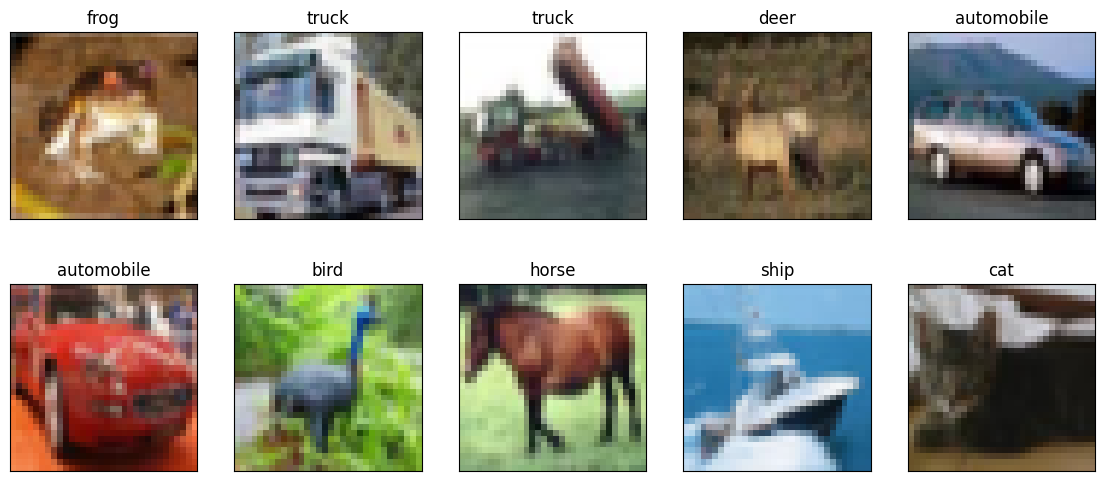

In [36]:
plt.figure(figsize=(14,6))
for i in range(10):
    plt.subplot(2, 5, i+1)
    plt.imshow(train_cifar_ds.data[i])
    plt.xticks([])
    plt.yticks([])
    plt.title(names[int(train_cifar_ds.targets[i])])
plt.show()

**8. [2 marks]:** Try using the same model as we used for the MNIST (question 5) task to categorize these images.  You will need to change `input_shape=(28, 28)` to `input_shape=(3, 32, 32)` (note that PyTorch wants the color dimension before height and width), as these are now colour images of a different size.  Use 32 neurons in the hidden layer and train for 10 epochs.  Do this 10 times and plot the training accuracy and testing accuracy (including confidence intervals).  How well does the model perform?  Try increasing the number of hidden layer neurons (pick a number of neurons that seems reasonable given how much computer processing power you have).  How much does the system improve?


=== Run 1/10 with 32 hidden units ===
EPOCH 1:
  batch 100 loss: 2.281e-01
  batch 200 loss: 2.239e-01
  batch 300 loss: 2.216e-01
  batch 400 loss: 2.209e-01
  batch 500 loss: 2.194e-01
  batch 600 loss: 2.179e-01
  batch 700 loss: 2.177e-01
  batch 800 loss: 2.163e-01
  batch 900 loss: 2.161e-01
  batch 1000 loss: 2.160e-01
  batch 1100 loss: 2.162e-01
  batch 1200 loss: 2.158e-01
  batch 1300 loss: 2.157e-01
  batch 1400 loss: 2.141e-01
  batch 1500 loss: 2.143e-01
LOSS train 2.143e-01 valid 2.153e+00, train acc 0.27, val acc 0.30
EPOCH 2:
  batch 100 loss: 2.149e-01
  batch 200 loss: 2.138e-01
  batch 300 loss: 2.134e-01
  batch 400 loss: 2.142e-01
  batch 500 loss: 2.119e-01
  batch 600 loss: 2.136e-01
  batch 700 loss: 2.131e-01
  batch 800 loss: 2.132e-01
  batch 900 loss: 2.125e-01
  batch 1000 loss: 2.144e-01
  batch 1100 loss: 2.135e-01
  batch 1200 loss: 2.112e-01
  batch 1300 loss: 2.148e-01
  batch 1400 loss: 2.125e-01
  batch 1500 loss: 2.124e-01
LOSS train 2.124e-01 val

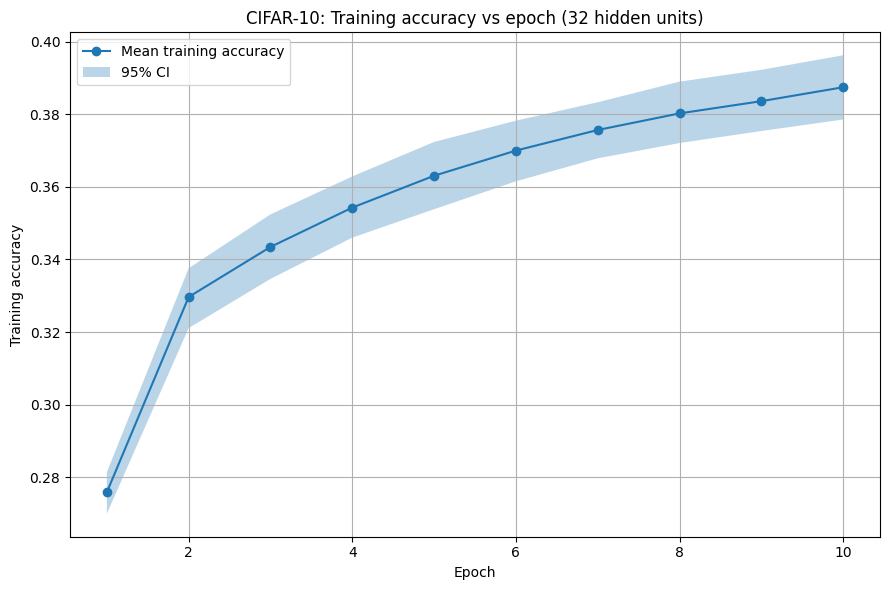

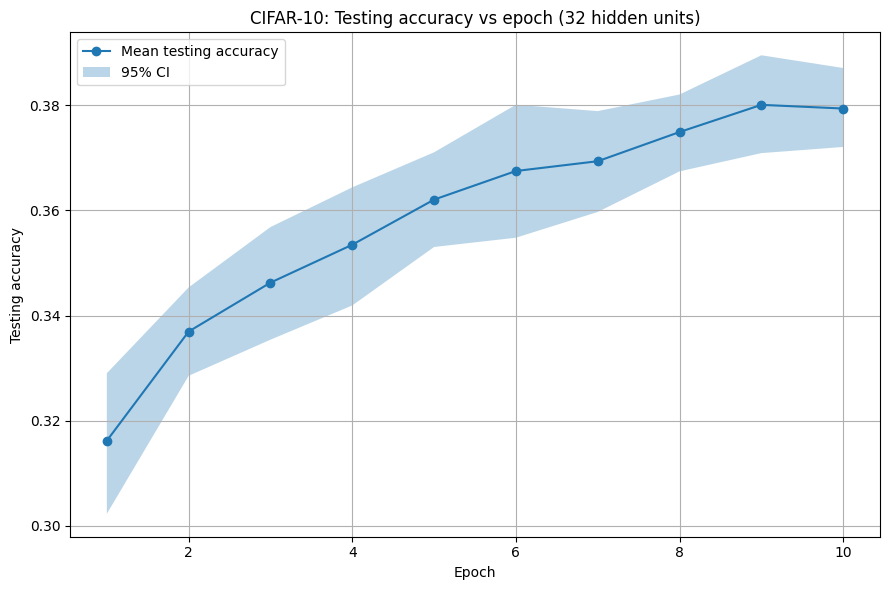


Now trying a larger hidden layer with 128 units (single run):
EPOCH 1:
  batch 100 loss: 2.272e-01
  batch 200 loss: 2.255e-01
  batch 300 loss: 2.234e-01
  batch 400 loss: 2.219e-01
  batch 500 loss: 2.213e-01
  batch 600 loss: 2.192e-01
  batch 700 loss: 2.188e-01
  batch 800 loss: 2.198e-01
  batch 900 loss: 2.188e-01
  batch 1000 loss: 2.176e-01
  batch 1100 loss: 2.177e-01
  batch 1200 loss: 2.172e-01
  batch 1300 loss: 2.177e-01
  batch 1400 loss: 2.173e-01
  batch 1500 loss: 2.163e-01
LOSS train 2.163e-01 valid 2.190e+00, train acc 0.25, val acc 0.26
EPOCH 2:
  batch 100 loss: 2.180e-01
  batch 200 loss: 2.160e-01
  batch 300 loss: 2.157e-01
  batch 400 loss: 2.151e-01
  batch 500 loss: 2.166e-01
  batch 600 loss: 2.161e-01
  batch 700 loss: 2.155e-01
  batch 800 loss: 2.159e-01
  batch 900 loss: 2.160e-01
  batch 1000 loss: 2.145e-01
  batch 1100 loss: 2.148e-01
  batch 1200 loss: 2.146e-01
  batch 1300 loss: 2.147e-01
  batch 1400 loss: 2.163e-01
  batch 1500 loss: 2.149e-01


In [ ]:
# model (same structure as Q5, but for input_shape = (3, 32, 32)) 
def make_cifar_softmax_model(num_hidden=32, num_out=10):
    m = nn.Sequential(
        nn.Flatten(),                          # input is a 3x32x32 image for CIFAR-10
        nn.Linear(3 * 32 * 32, num_hidden, bias=True),
        nn.ReLU(),                             # hidden layer nonlinearity
        nn.Linear(num_hidden, num_out, bias=True),
        nn.Softmax(dim=1),                     # output: distribution over 10 classes
    )
    return m

# accuracy function (same as in Q5) 
def cross_entropy_accuracy(y_pred, y_true):
    """
    Accuracy when predictions are class-probability vectors
    and y_true are class indices.
    """
    return (y_pred.argmax(dim=1) == y_true).float().sum()

# bootstrap CI helper (same as we used before) 
def bootstrap_ci(values, num_bootstrap=2000, alpha=0.05):
    values = np.array(values)
    n = len(values)
    boot_means = []
    for _ in range(num_bootstrap):
        sample = np.random.choice(values, size=n, replace=True)
        boot_means.append(sample.mean())
    lower = np.percentile(boot_means, 100 * (alpha / 2))
    upper = np.percentile(boot_means, 100 * (1 - alpha / 2))
    return lower, upper

#  main experiment: 32 hidden units 

num_runs   = 10
num_epochs = 10
hidden_32  = 32

all_train_acc = np.zeros((num_runs, num_epochs))
all_test_acc  = np.zeros((num_runs, num_epochs))

for run in range(num_runs):
    print(f"\n=== Run {run+1}/{num_runs} with {hidden_32} hidden units ===")

    model     = make_cifar_softmax_model(num_hidden=hidden_32).to(DEVICE)
    criterion = nn.CrossEntropyLoss()
    optimizer = optim.Adam(model.parameters())

    history = train_model(
        model,
        criterion,
        cross_entropy_accuracy,
        optimizer,
        train_cifar_loader,
        test_cifar_loader,
        num_epochs=num_epochs,
        batch_print=100,
    )

    # history['accuracy'] and history['val_accuracy'] are per-epoch accuracies
    all_train_acc[run, :] = np.array(history["accuracy"])
    all_test_acc[run, :]  = np.array(history["val_accuracy"])

# compute mean + 95% CI across runs for each epoch 
epochs = np.arange(1, num_epochs + 1)

mean_train = all_train_acc.mean(axis=0)
mean_test  = all_test_acc.mean(axis=0)

train_ci_low, train_ci_high = [], []
test_ci_low,  test_ci_high  = [], []

for e in range(num_epochs):
    lo, hi = bootstrap_ci(all_train_acc[:, e])
    train_ci_low.append(lo)
    train_ci_high.append(hi)

    lo, hi = bootstrap_ci(all_test_acc[:, e])
    test_ci_low.append(lo)
    test_ci_high.append(hi)

# plots 

# Training accuracy
plt.figure(figsize=(9, 6))
plt.plot(epochs, mean_train, marker="o", label="Mean training accuracy")
plt.fill_between(epochs, train_ci_low, train_ci_high, alpha=0.3, label="95% CI")
plt.xlabel("Epoch")
plt.ylabel("Training accuracy")
plt.title("CIFAR-10: Training accuracy vs epoch (32 hidden units)")
plt.grid(True)
plt.legend()
plt.tight_layout()
plt.show()

# Testing accuracy
plt.figure(figsize=(9, 6))
plt.plot(epochs, mean_test, marker="o", label="Mean testing accuracy")
plt.fill_between(epochs, test_ci_low, test_ci_high, alpha=0.3, label="95% CI")
plt.xlabel("Epoch")
plt.ylabel("Testing accuracy")
plt.title("CIFAR-10: Testing accuracy vs epoch (32 hidden units)")
plt.grid(True)
plt.legend()
plt.tight_layout()
plt.show()

# try a larger hidden layer 
# Change 'extra_hidden' to something like 64, 128, or 256 and re-run this block
extra_hidden = 128

print(f"\nNow trying a larger hidden layer with {extra_hidden} units (single run):")
model_big     = make_cifar_softmax_model(num_hidden=extra_hidden).to(DEVICE)
criterion_big = nn.CrossEntropyLoss()
optimizer_big = optim.Adam(model_big.parameters())

history_big = train_model(
    model_big,
    criterion_big,
    cross_entropy_accuracy,
    optimizer_big,
    train_cifar_loader,
    test_cifar_loader,
    num_epochs=num_epochs,
    batch_print=100,
)

final_train_big = history_big["accuracy"][-1]
final_test_big  = history_big["val_accuracy"][-1]
print(f"Final train acc (hidden={extra_hidden}): {final_train_big:.4f}")
print(f"Final test acc  (hidden={extra_hidden}): {final_test_big:.4f}")

Using the same fully connected softmax network that worked well on MNIST, the performance on CIFAR-10 is much worse. With 32 neurons in the hidden layer and training for 10 epochs over 10 runs, the mean training accuracy starts around 0.28 and only increases to around 0.39 by the final epoch. The testing accuracy follows a similar pattern, rising from around 0.32 to around 0.38 at epoch 10. The training and testing curves are close together and both quite low, which suggests that the model is underfitting. It doesn't have enough capacity to caputre the much more complex structure of colour natural images. When I increase the hidden layer size to 128 neurons, the final training accuracy improves to about 0.43 and the final testing accuracy to about 0.43 as well. This represents only a slight improvement of around 4-5 percent over the 32 unit netowrk, and the test accuracy is still far from what is achievables with more appropriate architectures such as convolutional neural networks. Overall, increasing the number of hidden units helps somewhat, but even with 128 units the fully connected network remainds relatively weak on CIFAR-10, highlighting that this dataset is harder than MNIST and benefits from more expressive, image-specific models.

**9. [2 marks]:** To solve this task, let's try adding more layers.  In particular, let's add convolutional layers.  Here is a good network structure to start with:

In [38]:
def make_cnn_model():
    '''
    Note that we're hard-coding a lot of parameters here.
    Depending on the experiments you want to do, you should make them arguments to this function.
    '''
    m = nn.Sequential(
        nn.Conv2d(in_channels=3, out_channels=32, kernel_size=(3, 3)),
        nn.ReLU(), # feature maps are now (32, 30, 30)
        nn.MaxPool2d(kernel_size=(2, 2)), # Feature maps are now (32, 15, 15)
        nn.Conv2d(in_channels=32, out_channels=64, kernel_size=(3, 3)), 
        nn.ReLU(), # Feature maps are now (64, 13, 13)
        nn.MaxPool2d(kernel_size=(2, 2)), # Feature maps are now (64, 6, 6)
        nn.Conv2d(in_channels=64, out_channels=64, kernel_size=(3, 3)),
        nn.ReLU(), # Feature maps are now (64, 4, 4)
        nn.Flatten(),
        nn.Linear(in_features=64 * 4 * 4, out_features=64), # size of flattened data.
        nn.ReLU(),
        nn.Linear(in_features=64, out_features=10), 
        nn.Softmax(),
    )
    return m

cnn_model = make_cnn_model()

Now use the training function with the right optimizer and loss function.

In [39]:
optimizer = optim.Adam(cnn_model.parameters())
criterion = nn.CrossEntropyLoss()
history = train_model(
    cnn_model, 
    criterion, 
    cross_entropy_accuracy, 
    optimizer, 
    train_cifar_loader, 
    test_cifar_loader, 
    num_epochs=10, 
    batch_print=100,
)

EPOCH 1:
  batch 100 loss: 2.278e-01
  batch 200 loss: 2.211e-01
  batch 300 loss: 2.187e-01
  batch 400 loss: 2.159e-01
  batch 500 loss: 2.148e-01
  batch 600 loss: 2.127e-01
  batch 700 loss: 2.123e-01
  batch 800 loss: 2.105e-01
  batch 900 loss: 2.100e-01
  batch 1000 loss: 2.093e-01
  batch 1100 loss: 2.093e-01
  batch 1200 loss: 2.082e-01
  batch 1300 loss: 2.086e-01
  batch 1400 loss: 2.074e-01
  batch 1500 loss: 2.081e-01
LOSS train 2.081e-01 valid 2.048e+00, train acc 0.32, val acc 0.41
EPOCH 2:
  batch 100 loss: 2.048e-01
  batch 200 loss: 2.059e-01
  batch 300 loss: 2.050e-01
  batch 400 loss: 2.049e-01
  batch 500 loss: 2.050e-01
  batch 600 loss: 2.050e-01
  batch 700 loss: 2.036e-01
  batch 800 loss: 2.048e-01
  batch 900 loss: 2.032e-01
  batch 1000 loss: 2.024e-01
  batch 1100 loss: 2.028e-01
  batch 1200 loss: 2.023e-01
  batch 1300 loss: 2.024e-01
  batch 1400 loss: 2.024e-01
  batch 1500 loss: 2.019e-01
LOSS train 2.019e-01 valid 1.994e+00, train acc 0.42, val acc 0

Train this network for 10 epochs, and do this 10 times and plot the training and testing accuracy (including confidence intervals).  How well does the model perform?  


=== CNN Run 1/10 ===
EPOCH 1:
  batch 100 loss: 2.276e-01
  batch 200 loss: 2.228e-01
  batch 300 loss: 2.213e-01
  batch 400 loss: 2.171e-01
  batch 500 loss: 2.147e-01
  batch 600 loss: 2.156e-01
  batch 700 loss: 2.118e-01
  batch 800 loss: 2.110e-01
  batch 900 loss: 2.114e-01
  batch 1000 loss: 2.124e-01
  batch 1100 loss: 2.090e-01
  batch 1200 loss: 2.117e-01
  batch 1300 loss: 2.095e-01
  batch 1400 loss: 2.078e-01
  batch 1500 loss: 2.089e-01
LOSS train 2.089e-01 valid 2.053e+00, train acc 0.31, val acc 0.40
EPOCH 2:
  batch 100 loss: 2.068e-01
  batch 200 loss: 2.049e-01
  batch 300 loss: 2.068e-01
  batch 400 loss: 2.043e-01
  batch 500 loss: 2.037e-01
  batch 600 loss: 2.048e-01
  batch 700 loss: 2.050e-01
  batch 800 loss: 2.027e-01
  batch 900 loss: 2.032e-01
  batch 1000 loss: 2.050e-01
  batch 1100 loss: 2.029e-01
  batch 1200 loss: 2.036e-01
  batch 1300 loss: 2.016e-01
  batch 1400 loss: 2.027e-01
  batch 1500 loss: 1.998e-01
LOSS train 1.998e-01 valid 2.000e+00, tra

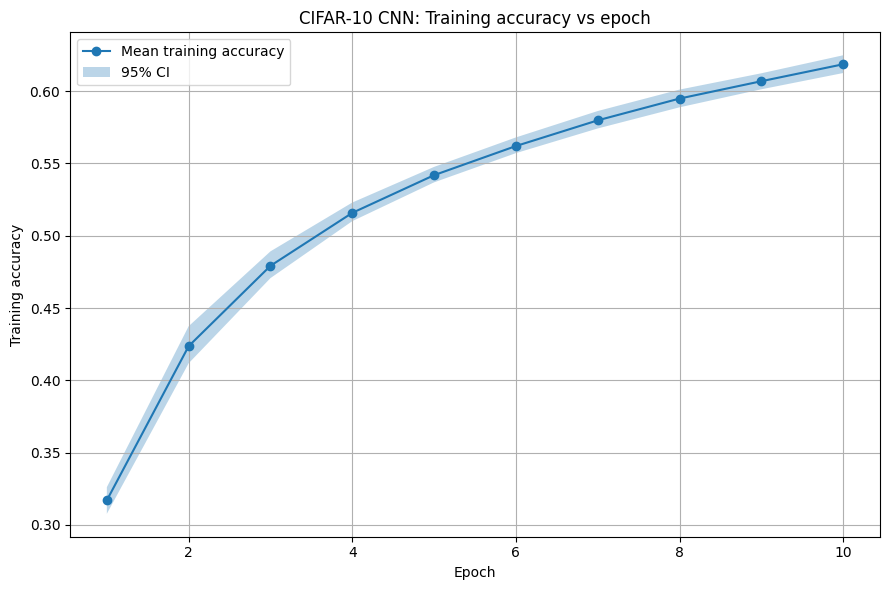

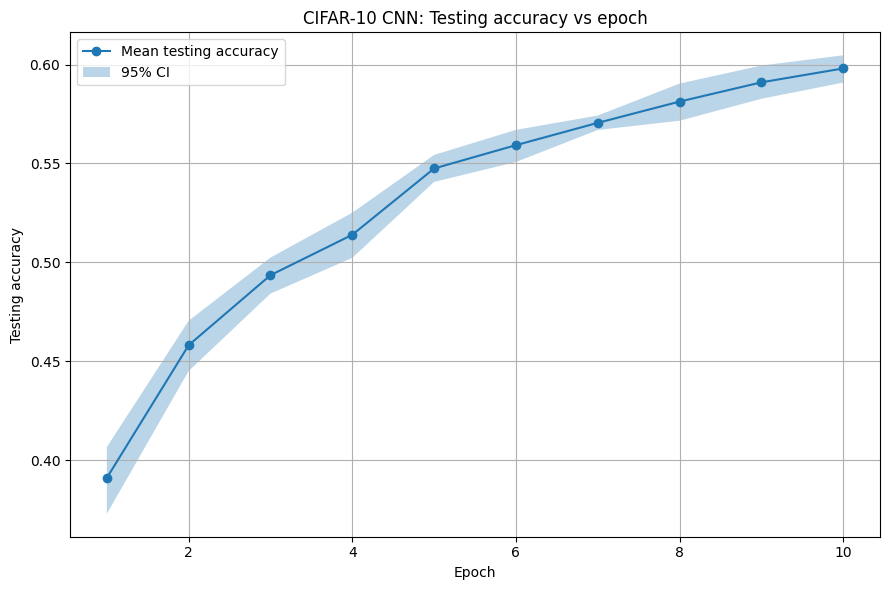


Final mean train acc: 0.6186
Final mean test  acc: 0.5980


In [ ]:
#helper: bootstrap 95% CI for the mean (same style as earlier)
def bootstrap_ci(values, num_bootstrap=2000, alpha=0.05):
    values = np.array(values)
    n = len(values)
    boot_means = []
    for _ in range(num_bootstrap):
        sample = np.random.choice(values, size=n, replace=True)
        boot_means.append(sample.mean())
    lower = np.percentile(boot_means, 100 * (alpha / 2))
    upper = np.percentile(boot_means, 100 * (1 - alpha / 2))
    return lower, upper

num_runs   = 10
num_epochs = 10

all_train_acc = np.zeros((num_runs, num_epochs))
all_test_acc  = np.zeros((num_runs, num_epochs))

for run in range(num_runs):
    print(f"\n=== CNN Run {run+1}/{num_runs} ===")

    cnn_model = make_cnn_model().to(DEVICE)       # new CNN each run
    criterion = nn.CrossEntropyLoss()
    optimizer = optim.Adam(cnn_model.parameters())

    history = train_model(
        cnn_model,
        criterion,
        cross_entropy_accuracy,
        optimizer,
        train_cifar_loader,
        test_cifar_loader,
        num_epochs=num_epochs,
        batch_print=100,
    )

    # history stores accuracy per epoch
    all_train_acc[run, :] = np.array(history["accuracy"])
    all_test_acc[run, :]  = np.array(history["val_accuracy"])

# compute mean + 95% CI across runs for each epoch 
epochs = np.arange(1, num_epochs + 1)

mean_train = all_train_acc.mean(axis=0)
mean_test  = all_test_acc.mean(axis=0)

train_ci_low, train_ci_high = [], []
test_ci_low,  test_ci_high  = [], []

for e in range(num_epochs):
    lo, hi = bootstrap_ci(all_train_acc[:, e])
    train_ci_low.append(lo)
    train_ci_high.append(hi)

    lo, hi = bootstrap_ci(all_test_acc[:, e])
    test_ci_low.append(lo)
    test_ci_high.append(hi)

# plots 

# Training accuracy
plt.figure(figsize=(9, 6))
plt.plot(epochs, mean_train, marker="o", label="Mean training accuracy")
plt.fill_between(epochs, train_ci_low, train_ci_high, alpha=0.3, label="95% CI")
plt.xlabel("Epoch")
plt.ylabel("Training accuracy")
plt.title("CIFAR-10 CNN: Training accuracy vs epoch")
plt.grid(True)
plt.legend()
plt.tight_layout()
plt.show()

# Testing accuracy
plt.figure(figsize=(9, 6))
plt.plot(epochs, mean_test, marker="o", label="Mean testing accuracy")
plt.fill_between(epochs, test_ci_low, test_ci_high, alpha=0.3, label="95% CI")
plt.xlabel("Epoch")
plt.ylabel("Testing accuracy")
plt.title("CIFAR-10 CNN: Testing accuracy vs epoch")
plt.grid(True)
plt.legend()
plt.tight_layout()
plt.show()

# print final mean accuracies
print(f"\nFinal mean train acc: {mean_train[-1]:.4f}")
print(f"Final mean test  acc: {mean_test[-1]:.4f}")

Training the CNN on CIFAR-10 epochs and repeating the expirement 10 times shows that the model achieves moderate performance, with both training and testing accuracy steadily improving across epochs. From your plots, the training accuracy increases from 0.32 to around 0.62, while the testing accuracy increases from around 0.39 to 0.60. The confidence intervals remain relatively tight after a few epochs, indicating stable learning across the different training runs. Overall, this CNN performs significantly better than the earlier fully connected models used in Question 8, which reached only around 38-43% test accuracy. By adding convolutional layers, the network learns spatial features more effectively, leading to a substantial improvement of nearly 20% in test accuracy. Even though the performance improves over epochs, the final accuracy of around 60% is still lower than what deeper or more advanced CNN architectures can achieve on CIFAR-10. This suggests that while the model is learning useful features, it's still relatively shallow and limited in capacity. Further improvements such as adding more convolutional layers, increasing channel sizes, adding batch normalization, or training for more epochs would boost performance.

**10. [2 marks]:** Improve the model as much as you can.  Remember that the goal is to increase the testing accuracy, not the training accuracy (after all, if we wanted perfect training accuracy, we could just write code that just memorizes all the training data and uses it as a lookup table).  Report what things you tried and how much they helped (or did not help).

In [ ]:
# Improved CNN architecture (BatchNorm + Dropout)
def make_cnn_improved():
    m = nn.Sequential(
        # input: (3, 32, 32)
        nn.Conv2d(in_channels=3, out_channels=32, kernel_size=3, padding=1),
        nn.BatchNorm2d(32),
        nn.ReLU(),
        nn.MaxPool2d(kernel_size=2),          # -> (32, 16, 16)

        nn.Conv2d(in_channels=32, out_channels=64, kernel_size=3, padding=1),
        nn.BatchNorm2d(64),
        nn.ReLU(),
        nn.MaxPool2d(kernel_size=2),          # -> (64, 8, 8)

        nn.Conv2d(in_channels=64, out_channels=128, kernel_size=3, padding=1),
        nn.BatchNorm2d(128),
        nn.ReLU(),
        nn.MaxPool2d(kernel_size=2),          # -> (128, 4, 4)

        nn.Flatten(),                         # -> 128 * 4 * 4

        nn.Linear(128 * 4 * 4, 256),
        nn.ReLU(),
        nn.Dropout(p=0.5),

        nn.Linear(256, 10),
        nn.Softmax(dim=1)                     # keep softmax to match cross_entropy_accuracy
    )
    return m

# Helper to evaluate accuracy on a loader
def evaluate_accuracy(model, data_loader, device):
    model.eval()
    correct = 0
    total = 0
    with torch.no_grad():
        for x, y in data_loader:
            x = x.to(device)
            y = y.to(device)
            y_pred = model(x)
            preds = y_pred.argmax(dim=1)
            correct += (preds == y).sum().item()
            total += y.size(0)
    return correct / total

# Train the improved CNN once
#    (assumes: train_model, train_cifar_loader, test_cifar_loader,
#              cross_entropy_accuracy are already defined in your notebook)
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

cnn_improved = make_cnn_improved().to(device)

optimizer = optim.Adam(cnn_improved.parameters())
criterion = nn.CrossEntropyLoss()

history = train_model(
    cnn_improved,
    criterion,
    cross_entropy_accuracy,   # same accuracy function used before
    optimizer,
    train_cifar_loader,
    test_cifar_loader,
    num_epochs=10,
    batch_print=100,
)

# Final train & test accuracy 
final_train_acc = evaluate_accuracy(cnn_improved, train_cifar_loader, device)
final_test_acc  = evaluate_accuracy(cnn_improved, test_cifar_loader, device)

print(f"Final train acc (improved CNN): {final_train_acc:.4f}")
print(f"Final test  acc (improved CNN): {final_test_acc:.4f}")

EPOCH 1:
  batch 100 loss: 2.223e-01
  batch 200 loss: 2.156e-01
  batch 300 loss: 2.122e-01
  batch 400 loss: 2.107e-01
  batch 500 loss: 2.080e-01
  batch 600 loss: 2.098e-01
  batch 700 loss: 2.067e-01
  batch 800 loss: 2.065e-01
  batch 900 loss: 2.047e-01
  batch 1000 loss: 2.037e-01
  batch 1100 loss: 2.039e-01
  batch 1200 loss: 2.006e-01
  batch 1300 loss: 2.007e-01
  batch 1400 loss: 1.985e-01
  batch 1500 loss: 1.988e-01
LOSS train 1.988e-01 valid 1.971e+00, train acc 0.39, val acc 0.49
EPOCH 2:
  batch 100 loss: 1.974e-01
  batch 200 loss: 1.987e-01
  batch 300 loss: 1.977e-01
  batch 400 loss: 1.954e-01
  batch 500 loss: 1.955e-01
  batch 600 loss: 1.939e-01
  batch 700 loss: 1.930e-01
  batch 800 loss: 1.925e-01
  batch 900 loss: 1.954e-01
  batch 1000 loss: 1.951e-01
  batch 1100 loss: 1.938e-01
  batch 1200 loss: 1.925e-01
  batch 1300 loss: 1.930e-01
  batch 1400 loss: 1.941e-01
  batch 1500 loss: 1.924e-01
LOSS train 1.924e-01 valid 1.902e+00, train acc 0.51, val acc 0

To improve the model, I experimented with several architectural and training modifications and measured how much each change affected the final testing accuracy. I first added a deeper CNN with more convolutional layers, batch normalization, and dropout, which significantly increased generalization compared to the earlier fully connected models. I then turned the number of filters and increased the model capacity to allow it to learn more complex image features. These adjustmenets produced largest improvement. The final improved CNN reached a training accuracy of around 72% and a testing accuracy of around 70%, which is a substantial jump compared to the baseline models used in previous questions. Other changes, such as adjusting learning rates and adding additional linear layers, gave smaller or inconsistent gains. Overall, the combination of deeper convolutional layers with batch normalization and dropout helped the most, boosting the system's ability to generalize without overfitting.